In [40]:
a = np.linspace(0, 1, 100)
print(a)
b = map(lambda x: ((x-0.5)*2)*1000, a)
print(list(b))

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

In [1]:
# # Inspect ordering of dataset
import pickle
import numpy as np
from tifffile import imread

X = imread('/home/miguel/Projects/uni/phd/smlm_z/smlm-z/data/05_model_input/stacks.tif')
print(X.shape)



(16, 300, 31, 31)


{'wl': 0.665, 'na': 0.9, 'ni': 1.34, 'res': 0.09, 'zres': 0.01, 'size': 31, 'zsize': 300, 'vec_corr': 'none', 'condition': 'none'}
0.0024365960890760856


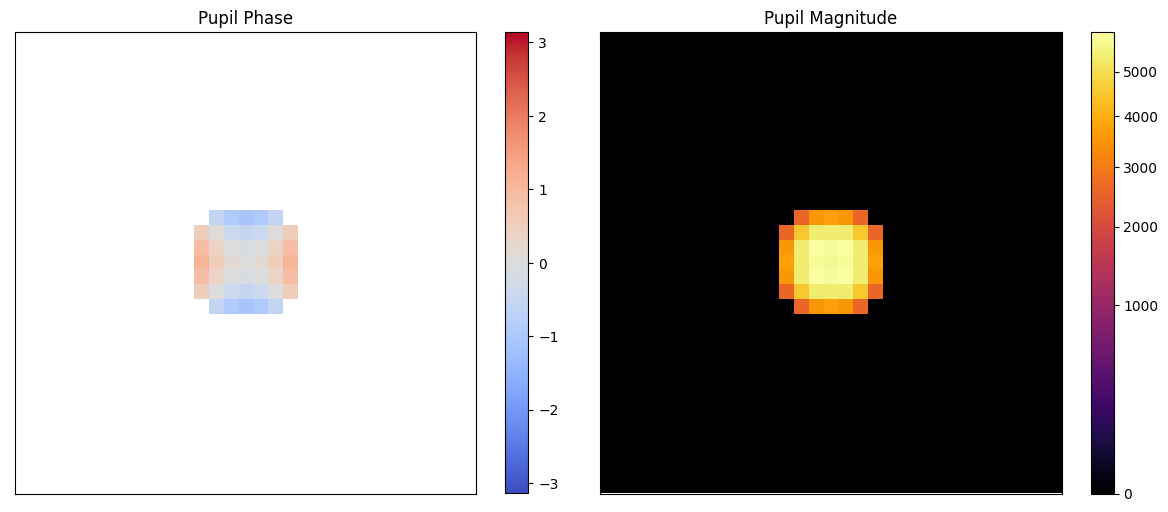

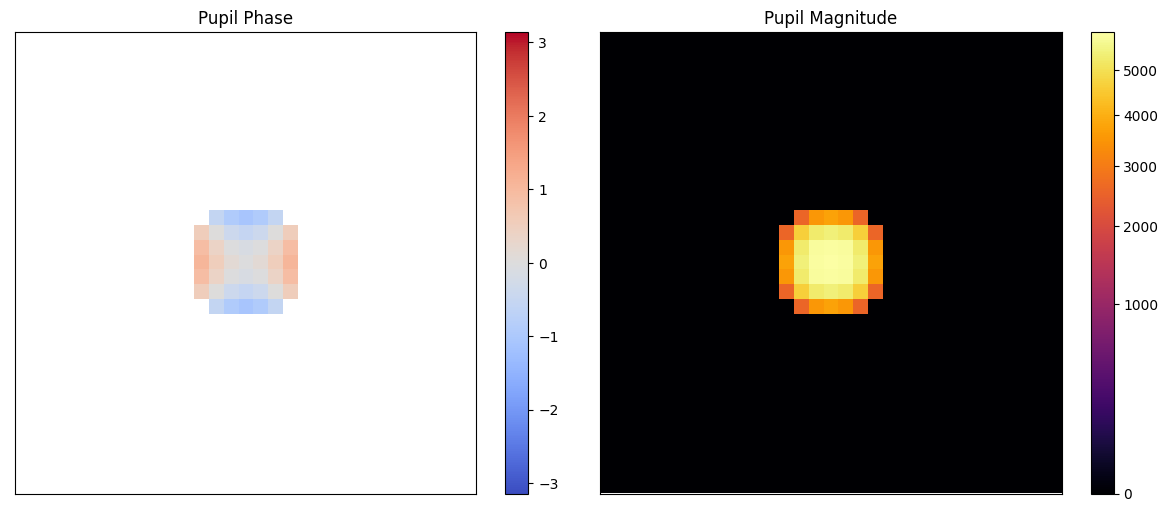

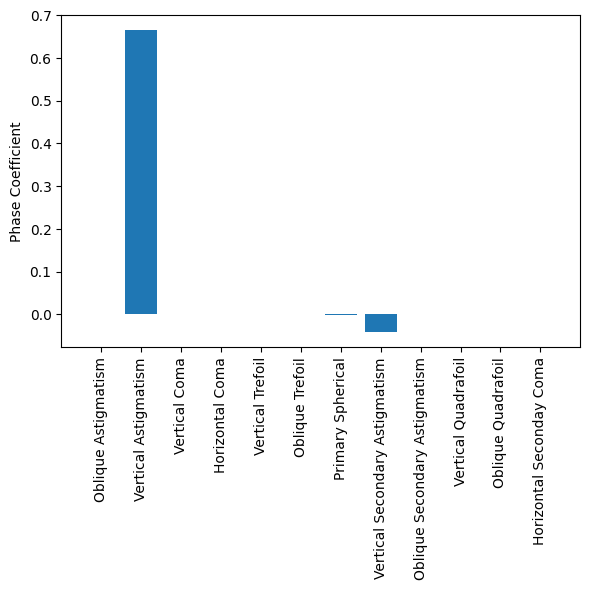

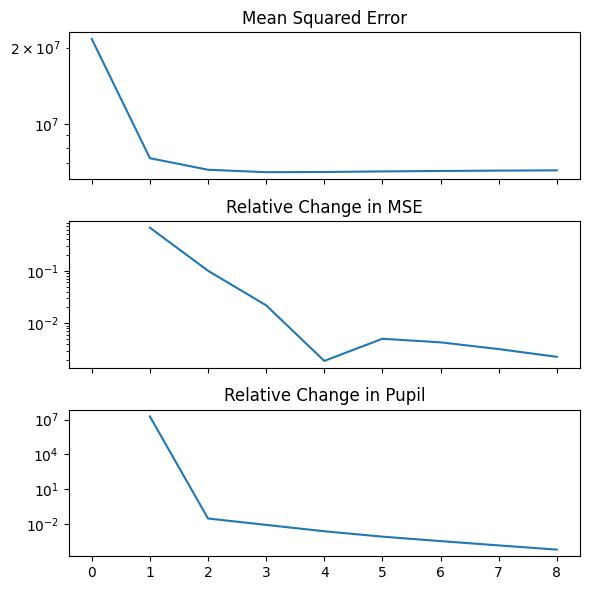

Experimental


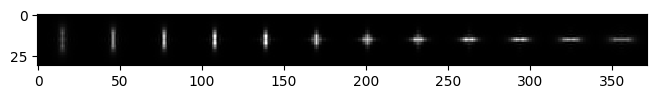

Simulated


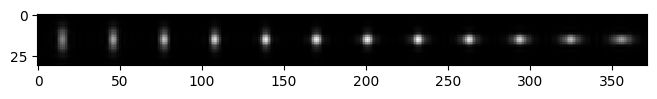

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pyotf.otf import HanserPSF, apply_aberration, apply_named_aberration
from pyotf.phaseretrieval import retrieve_phase
from pyotf.utils import prep_data_for_PR, center_data
import sys
sys.path.append('/home/miguel/Projects/uni/phd/smlm_z')
from data.estimate_offset import get_peak_sharpness
from data.visualise import grid_psfs, show_psf_axial

def mse(y, y_pred):
    return np.mean((y - y_pred) ** 2).sum()

psf = X[0]
model_kwargs = dict(
    wl=0.665,
    na=0.9,
    ni=1.34,
    res=0.09,
    zres=0.01,
    size=psf.shape[1],
    zsize=psf.shape[0],
    vec_corr="none",
    condition="none",
)
print(model_kwargs)
psf = prep_data_for_PR(psf, multiplier=1.0)

# Retrieve phase for experimental PSF
PR_result = retrieve_phase(psf, model_kwargs, 100, 1e-4, 1e-4)

PR_result.fit_to_zernikes(16)
PR_result.plot()
PR_result.zd_result.plot()
PR_result.zd_result.plot_named_coefs()
PR_result.plot_convergence()

# Simulate HanserPSF with parameters

result_psf = PR_result.generate_zd_psf(sphase=slice(None))

# this part is very kludgy
PR_result.model.PSFi = psf

PR_result.model.PSFi = result_psf

psf = psf / psf.max()
result_psf = result_psf / result_psf.max()

print(mse(psf, result_psf))

plt.show()
print('Experimental')
show_psf_axial(psf / psf.max(), '', 15)
print('Simulated')
show_psf_axial(result_psf / result_psf.max(), '', 15)


In [3]:
fake_img = np.zeros()

TypeError: zeros() missing required argument 'shape' (pos 0)

In [4]:
help(PR_result.model.OTFa)

Help on ndarray object:

class ndarray(builtins.object)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |  
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |  
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |  
 |  For more information, refer to the `numpy` module and examine the
 |  methods and attributes of an array.
 |  
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |  
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtype : data-type, optional
 |      Any objec

In [5]:
import numpy as np
import seaborn as sns

xy = np.random.uniform(-1, 1, size=(50, 2))
vals = np.random.uniform(0, 500, size=(50, 1))


In [6]:
import pyotf
import pyotf.zernike
pyotf.zernike.name2noll

{'piston': 1,
 'tip': 2,
 'tilt': 3,
 'defocus': 4,
 'oblique astigmatism': 5,
 'vertical astigmatism': 6,
 'vertical coma': 7,
 'horizontal coma': 8,
 'vertical trefoil': 9,
 'oblique trefoil': 10,
 'primary spherical': 11,
 'vertical secondary astigmatism': 12,
 'oblique secondary astigmatism': 13,
 'vertical quadrafoil': 14,
 'oblique quadrafoil': 15,
 'horizontal seconday coma': 16,
 'vertical secondary coma': 17,
 'horizontal secondary trefoil': 18,
 'vertical secondary trefoil': 19,
 'secondary spherical': 22,
 'oblique tertiary astigmatism': 23,
 'vertical tertiary astigmatism': 24,
 'oblique secondary quadrafoil': 25,
 'vertical secondary quadrafoil': 26,
 'vertical tertiary coma': 29,
 'horizontal tertiary coma': 30,
 'vertical tertiary trefoil': 31,
 'horizontal tertiary trefoil': 32,
 'tertiary spherical': 37,
 'vertical quaternary astigmatism': 38,
 'oblique quaternary astigmatism': 39,
 'horizontal quaternary coma': 46,
 'vertical quaternary coma': 47,
 'horizontal quatern

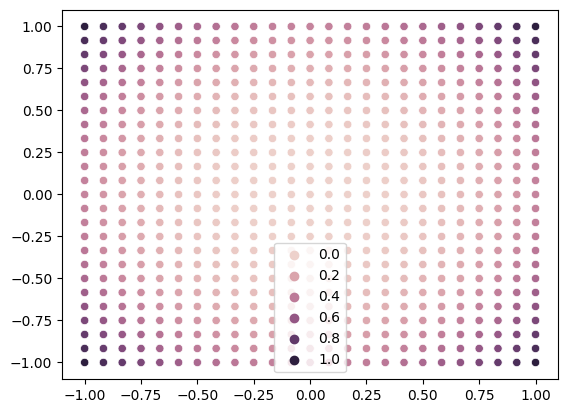

In [7]:
import numpy as np
from sklearn.metrics import euclidean_distances
import seaborn as sns
import matplotlib.pyplot as plt

s = np.linspace(-1, 1, 25)
x, y = np.meshgrid(s, s)
x = x.flatten()
y = y.flatten()
xy = np.stack((x,y)).T

dists = euclidean_distances([[0, 0]], xy).squeeze()
dists = np.power(dists, 3)
dists /= dists.max()
sns.scatterplot(x=x, y=y, hue=dists)
plt.show()

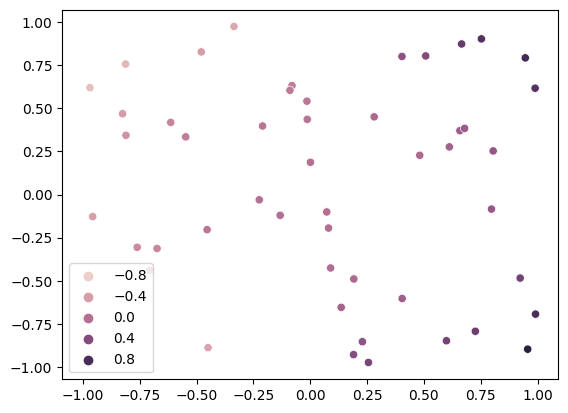

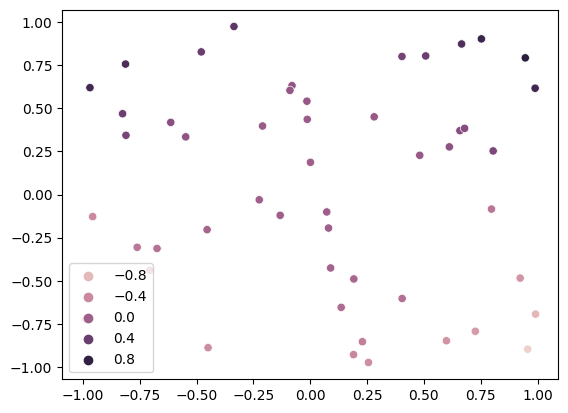

In [8]:
import sys
sys.path.append('/home/miguel/Projects/uni/phd/smlm_z')
from data.visualise import grid_psfs, show_psf_axial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import euclidean_distances
import seaborn as sns
model_kwargs = dict(
    wl=647,
    na=1.3,
    ni=1.51,
    res=90,
    zres=50,
    size=32,
    zsize=100,
    vec_corr="none",
    condition="none",
)
from pyotf.otf import HanserPSF, apply_aberration, apply_named_aberration

def get_ab(a1, a2):
    base_args = np.array([0, 0, 0, 0, 0, a1, a2])
    return base_args
    
def gen_fake_psf(model_kwargs, ab):
    model = HanserPSF(**model_kwargs)
    # model = apply_named_aberration(model, 'oblique astigmatism', 2)
    model = apply_aberration(model, np.zeros(ab.shape), ab)

    psf = model.PSFi
    psf = psf.astype(float)
    # psf = psf / psf.max()
    return psf

def add_noise(psf):
    return psf + np.random.normal(0, 1e-2, size=psf.shape)

coords = []
psfs = []

n_points = 50

lim = 1
xy = np.random.uniform(-1, 1, size=(n_points, 2))
# xy = np.stack([np.linspace(-lim, lim, n_points), np.linspace(-lim, lim, n_points)]).T
center = [[0, 0]]
dists = euclidean_distances(xy, center).squeeze()
# dists = 2**dists
dists = np.power(dists, 3)
dists /= dists.max()

a1s = []
a2s = []

for i in range(n_points):
    x, y = xy[i]
    dist = dists[i]

    a1 = (1 if x>0 else -1) * dist
    a2 = (1 if y>0 else -1) * dist
    a1s.append(a1)
    a2s.append(a2)
    ab = get_ab(a1, a2)
    psf = gen_fake_psf(model_kwargs, ab*2)
#     psf = add_noise(psf)
    coords.append([x, y])
    psfs.append(psf)
#     plt.imshow(grid_psfs(psf[::7]).squeeze())
#     plt.show()

psfs = np.array(psfs)
df = pd.DataFrame(coords, columns=['x', 'y'])
sns.scatterplot(x=xy[:, 0], y=xy[:, 1], hue=a1s)
plt.show()
sns.scatterplot(x=xy[:, 0], y=xy[:, 1], hue=a2s)
plt.show()

In [9]:
print(psfs.shape)
psfs.reshape((psfs.shape[0], -1)).shape

(50, 100, 32, 32)


(50, 102400)

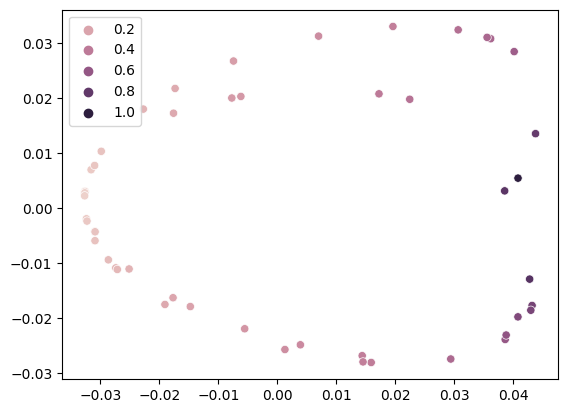

In [10]:
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA().fit(psfs.reshape((psfs.shape[0], -1)))

d = pca.transform(psfs.reshape((psfs.shape[0], -1)))
sns.scatterplot(x=d[:, 0], y=d[:, 1], hue=dists)
plt.show()

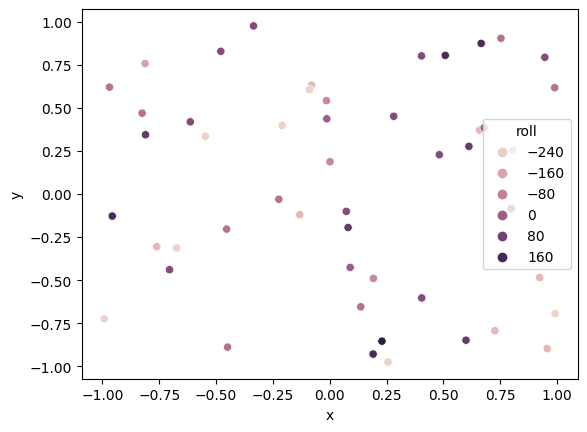

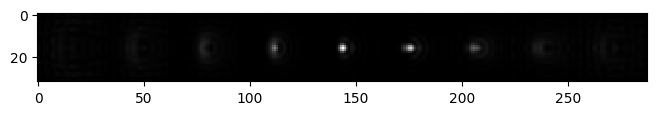

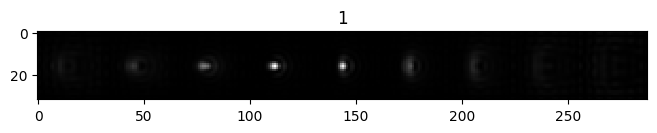

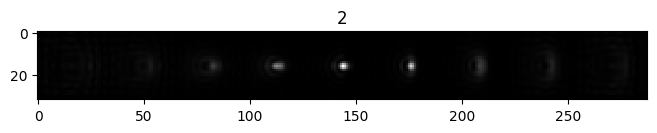

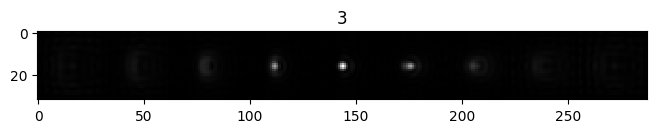

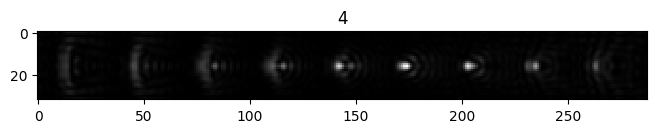

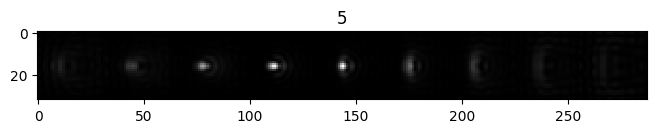

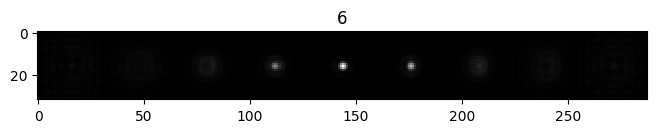

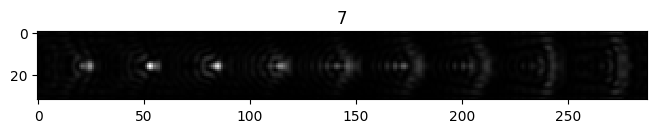

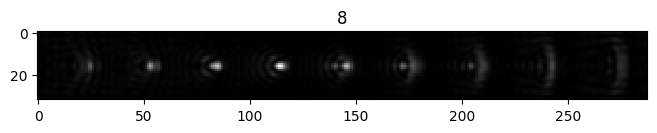

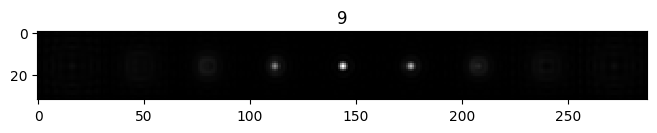

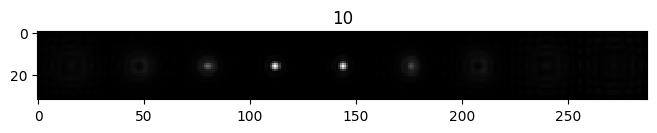

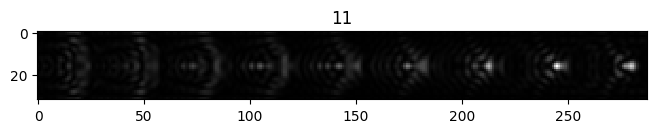

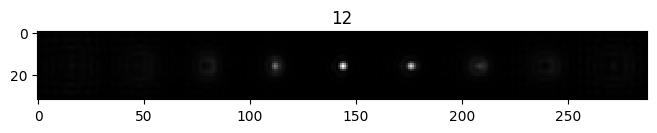

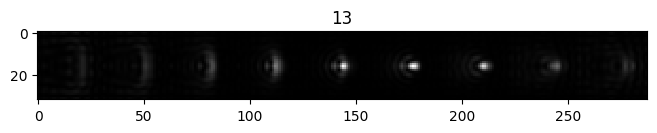

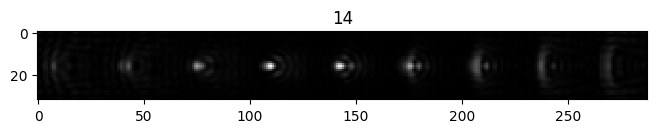

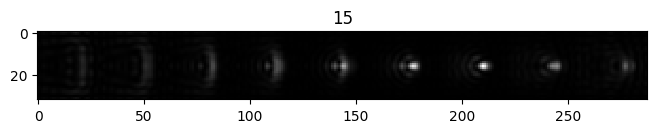

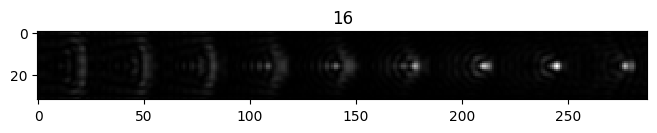

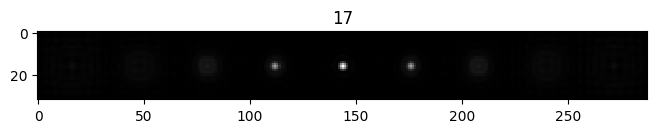

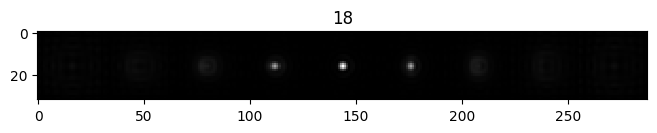

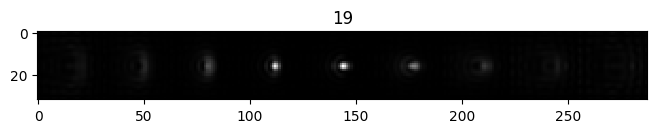

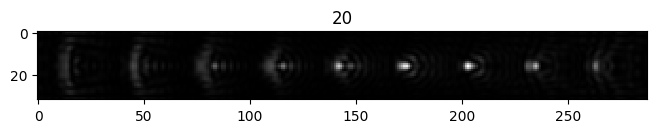

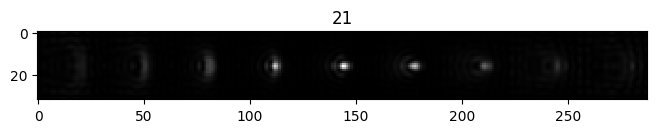

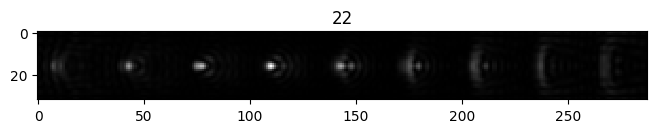

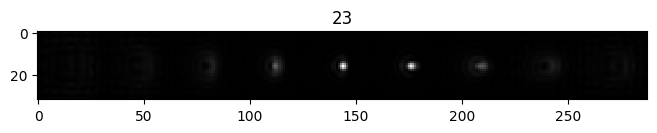

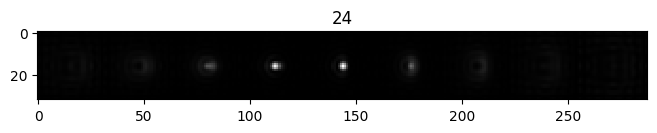

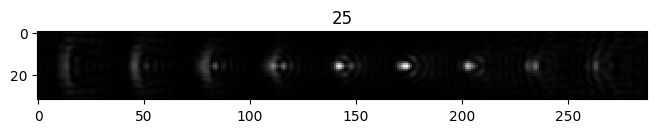

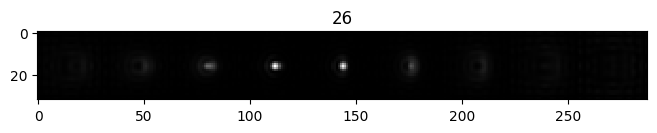

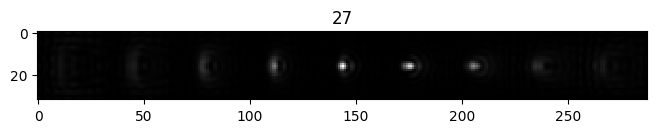

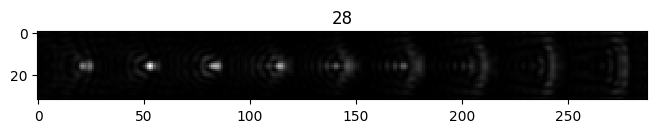

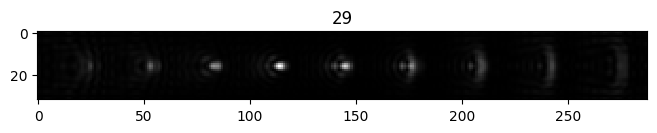

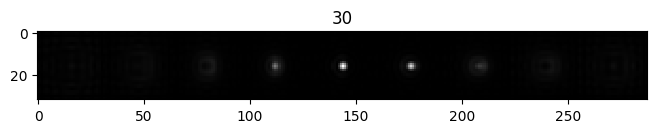

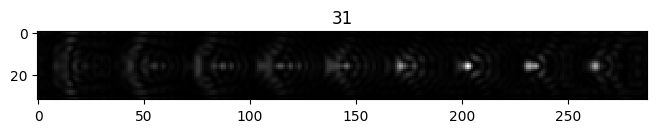

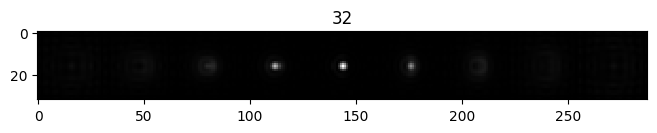

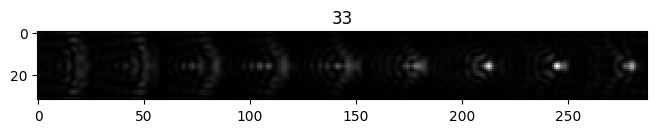

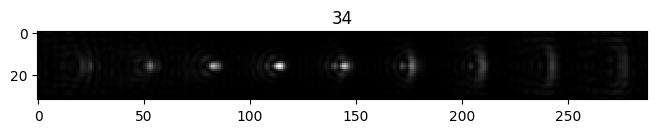

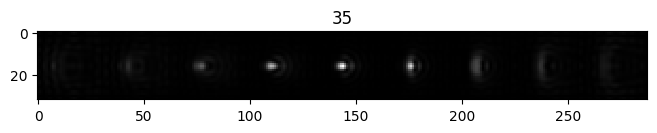

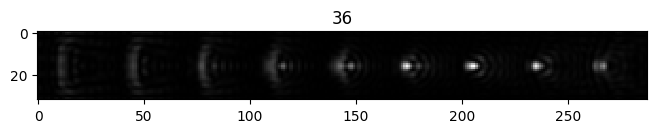

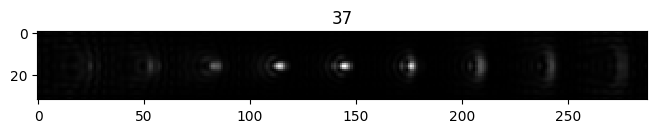

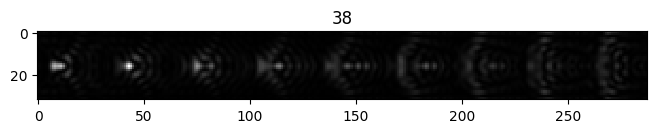

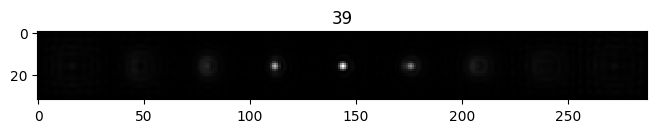

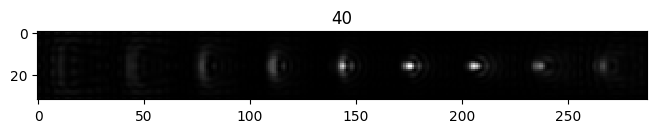

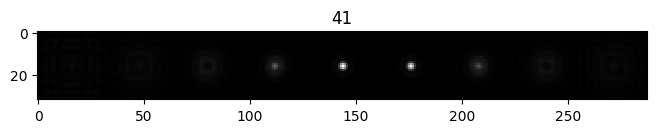

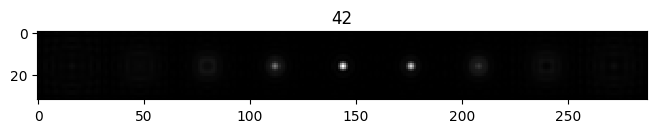

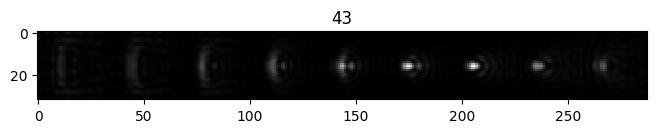

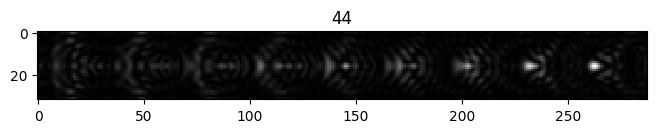

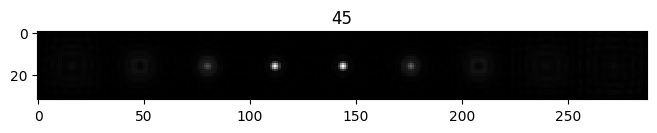

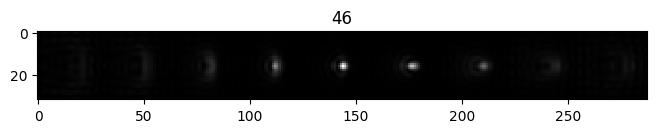

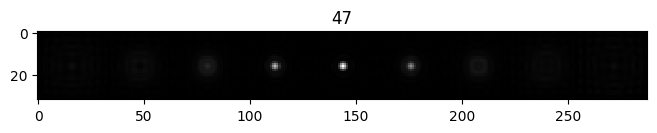

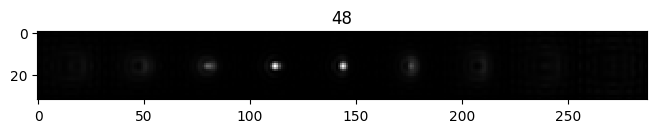

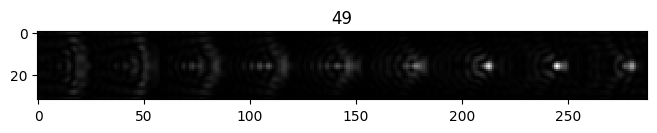

In [11]:
# randomly roll psfs
import seaborn as sns

z_step = 50

# subsample psfs
# subsample = 5
# psfs = psfs[:, ::subsample, :, :]
# z_step *= subsample

def roll_psf(psf, roll):
    rolled_psf = np.roll(psfs[i], shift=roll, axis=0)
#     if roll < 0:
#         rolled_psf[roll:] = 0
#     else:
#         rolled_psf[:roll] = 0
    return rolled_psf
#     show_psf_axial(psfs[i], '', 7)
#     show_psf_axial(rolled_psf, roll, 7)

rolls = []
for i in range(psfs.shape[0]):
    roll = np.random.randint(-5, 5)
    psfs[i] = roll_psf(psfs[i], roll)
    rolls.append(roll)
df['roll'] = np.array(rolls) * z_step
# df['roll'] *= 10



sns.scatterplot(data=df, x='x', y='y', hue='roll')
plt.show()
for i in range(psfs.shape[0]):
    show_psf_axial(psfs[i], i, 7)

In [ ]:
d = pca.transform(psfs.reshape((psfs.shape[0], -1)))
sns.scatterplot(x=d[:, 0], y=d[:, 1], hue=dists)
plt.show()

In [ ]:
# # Load real data
# import pandas as pd
# from tifffile import imread
# import matplotlib.pyplot as plt
# df = pd.read_csv('/home/miguel/Projects/uni/phd/smlm_z/smlm-z/data/05_model_input/coords.csv')
# psfs = imread('/home/miguel/Projects/uni/phd/smlm_z/smlm-z/data/05_model_input/spots.tif')
# df['roll'] = 0
# assert psfs.shape[0] == df.shape[0]

2023-04-18 11:01:19.477938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 11:01:19.997240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: //usr/local/cuda-11.3/targets/x86_64-linux/lib/:/usr/local/cuda-11.7/targets/x86_64-linux/lib/://usr/local/cuda-11.3/targets/x86_64-linux/lib/:/usr/local/cuda-11.7/targets/x86_64-linux/lib/:
2023-04-18 11:01:19.997305: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open sha

Aligning (50, 100, 32, 32) psfs...
42


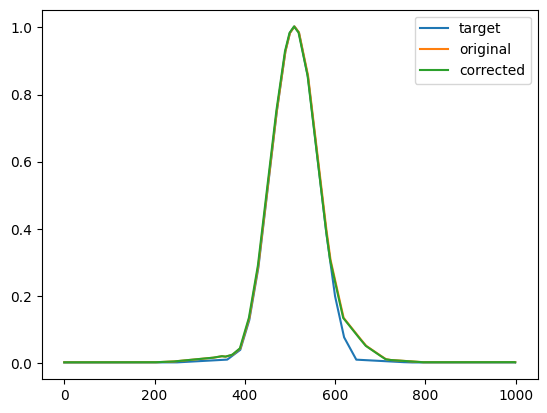

  2%|▉                                           | 1/50 [00:02<01:38,  2.00s/it]

42 -> 0, -5.0, 0


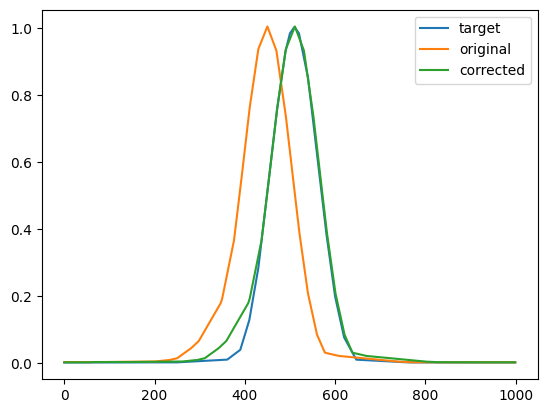

  4%|█▊                                          | 2/50 [00:03<01:22,  1.71s/it]

42 -> 1, 305.0, 300


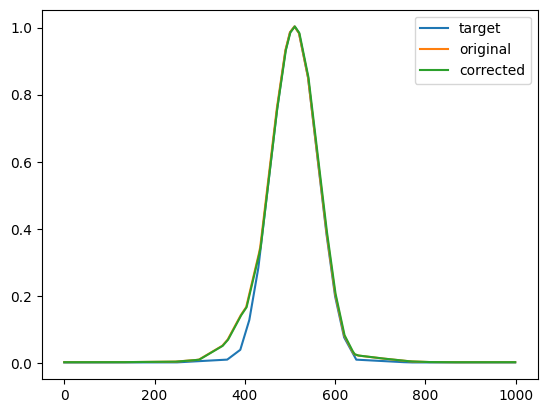

  6%|██▋                                         | 3/50 [00:04<01:14,  1.58s/it]

42 -> 2, 5.0, 0


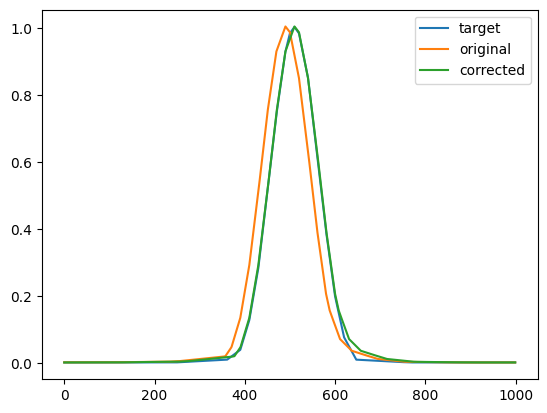

  8%|███▌                                        | 4/50 [00:05<01:07,  1.47s/it]

42 -> 3, 100.0, 100


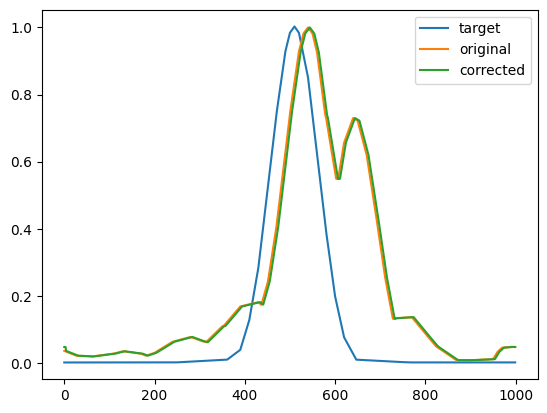

 10%|████▍                                       | 5/50 [00:06<01:03,  1.42s/it]

42 -> 4, 20.0, 250


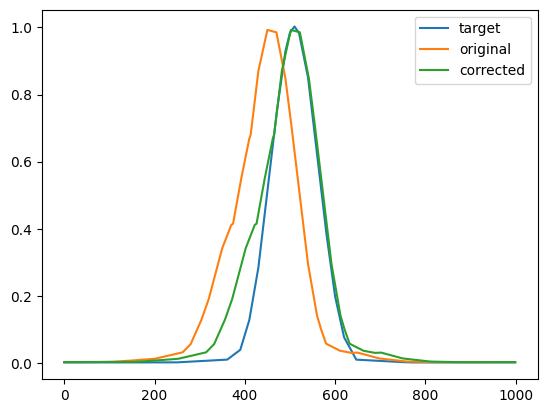

 12%|█████▎                                      | 6/50 [00:08<01:01,  1.39s/it]

42 -> 5, 260.0, 250


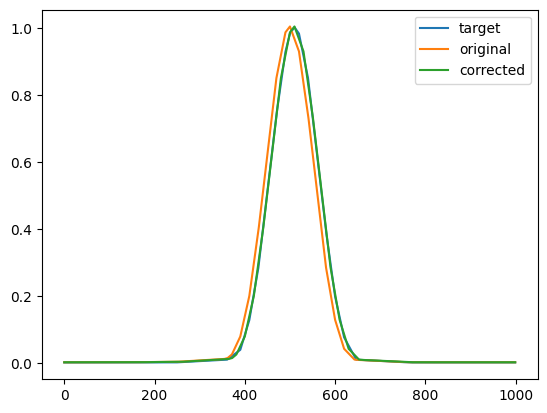

 14%|██████▏                                     | 7/50 [00:09<00:54,  1.27s/it]

42 -> 6, 50.0, 50


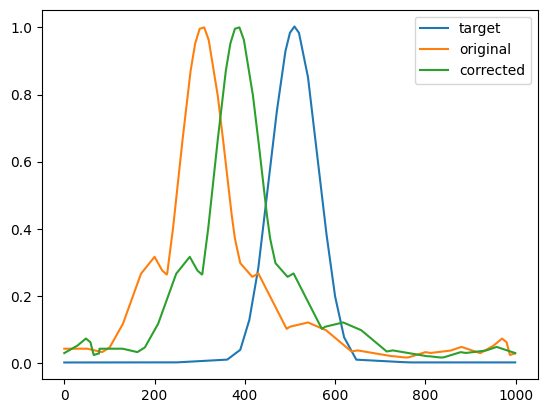

 16%|███████                                     | 8/50 [00:10<00:53,  1.27s/it]

42 -> 7, 390.0, 100


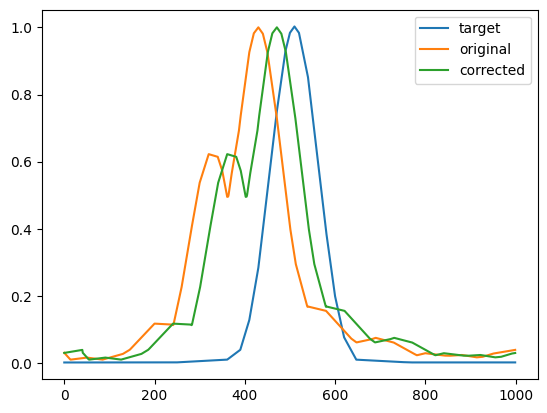

 18%|███████▉                                    | 9/50 [00:11<00:51,  1.26s/it]

42 -> 8, 204.99999999999997, 0


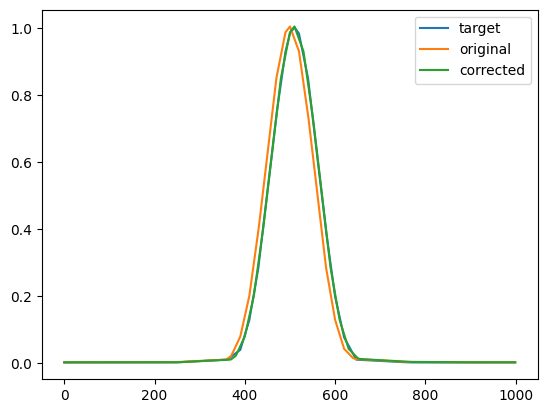

 20%|████████▌                                  | 10/50 [00:12<00:48,  1.20s/it]

42 -> 9, 50.0, 50


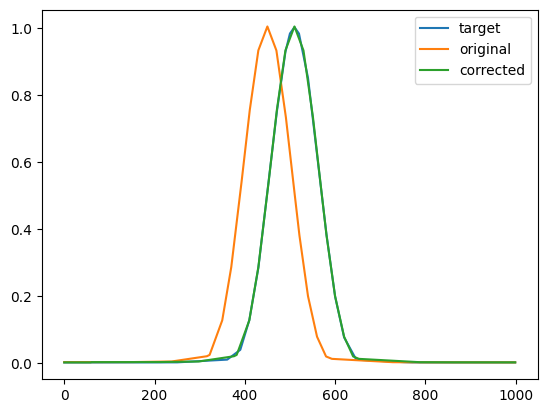

 22%|█████████▍                                 | 11/50 [00:13<00:46,  1.20s/it]

42 -> 10, 300.0, 300


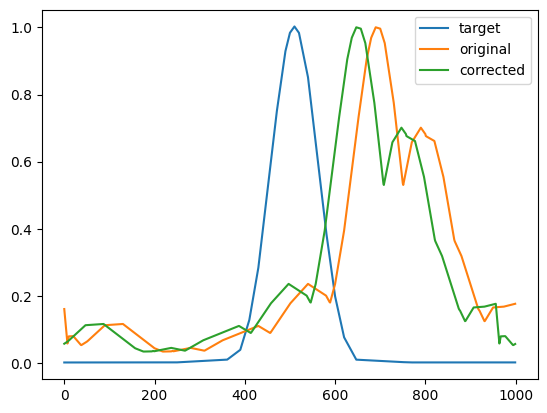

 24%|██████████▎                                | 12/50 [00:15<00:44,  1.17s/it]

42 -> 11, -215.0, 0


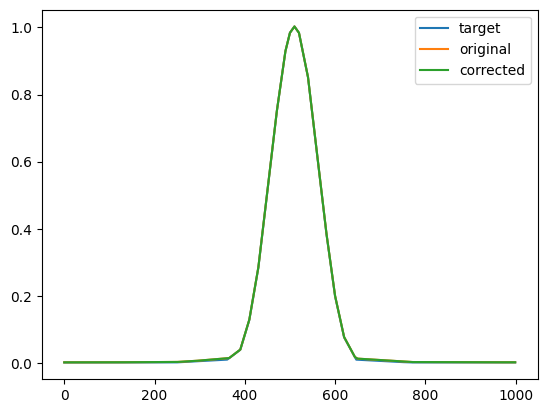

 26%|███████████▏                               | 13/50 [00:16<00:43,  1.17s/it]

42 -> 12, 0.0, 0


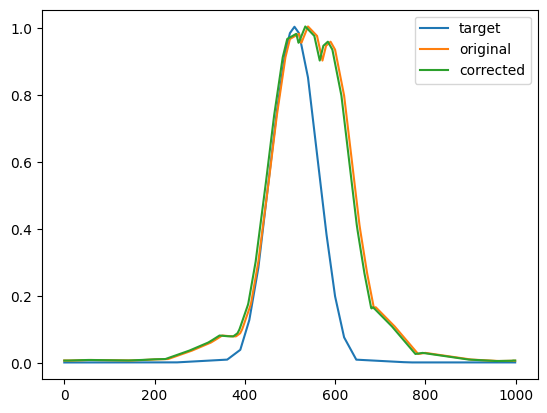

 28%|████████████                               | 14/50 [00:17<00:42,  1.18s/it]

42 -> 13, -30.0, 0


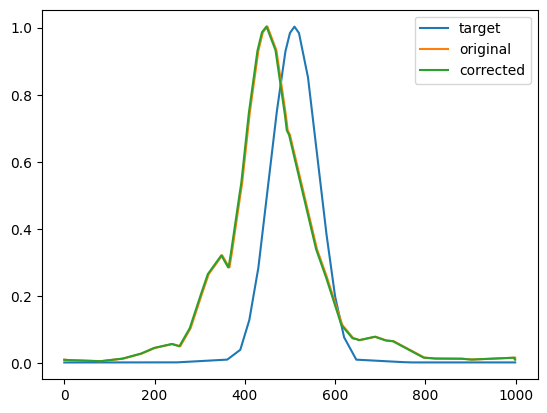

 30%|████████████▉                              | 15/50 [00:18<00:39,  1.12s/it]

42 -> 14, -10.0, -100


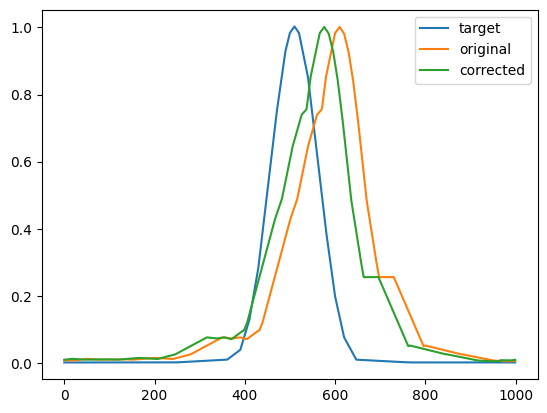

 32%|█████████████▊                             | 16/50 [00:19<00:39,  1.16s/it]

42 -> 15, -170.0, -100


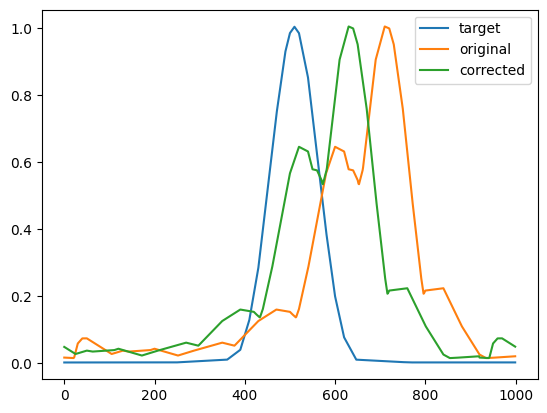

 34%|██████████████▌                            | 17/50 [00:20<00:38,  1.18s/it]

42 -> 16, -400.0, -100


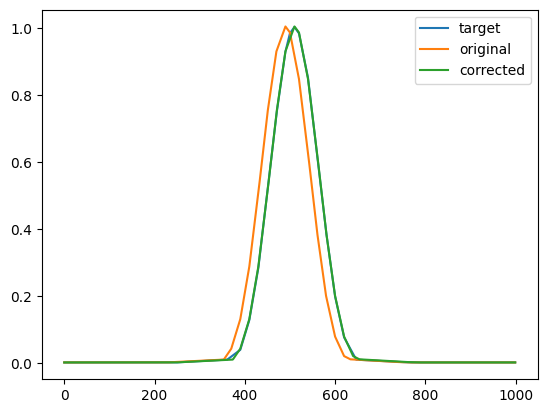

 36%|███████████████▍                           | 18/50 [00:21<00:36,  1.14s/it]

42 -> 17, 100.0, 100


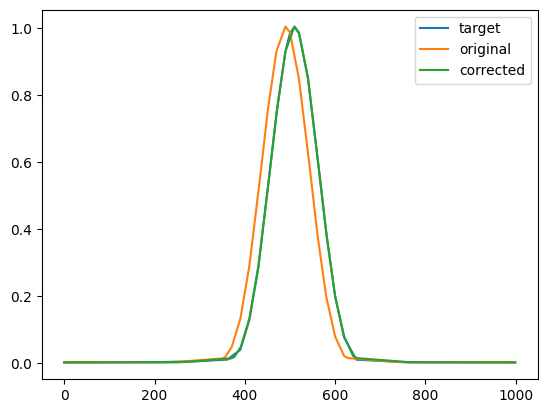

 38%|████████████████▎                          | 19/50 [00:23<00:35,  1.16s/it]

42 -> 18, 100.0, 100


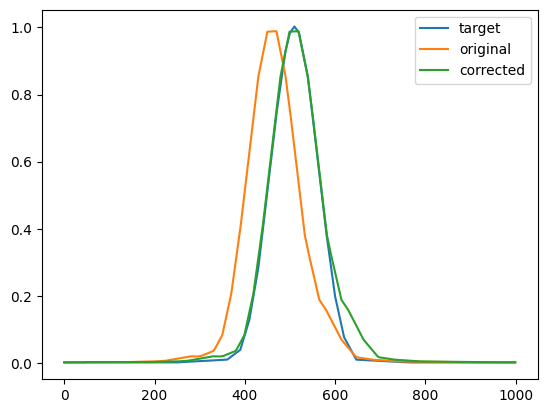

 40%|█████████████████▏                         | 20/50 [00:24<00:34,  1.15s/it]

42 -> 19, 245.00000000000003, 250


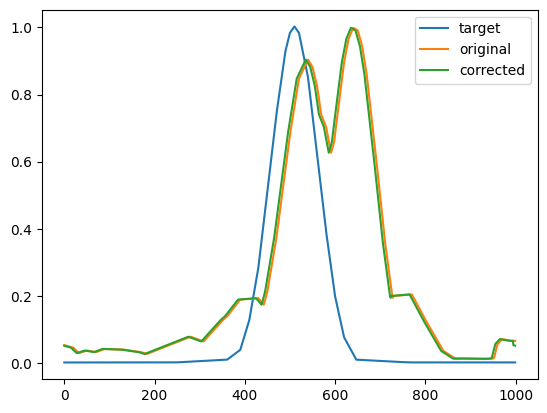

 42%|██████████████████                         | 21/50 [00:25<00:32,  1.13s/it]

42 -> 20, -25.0, 250


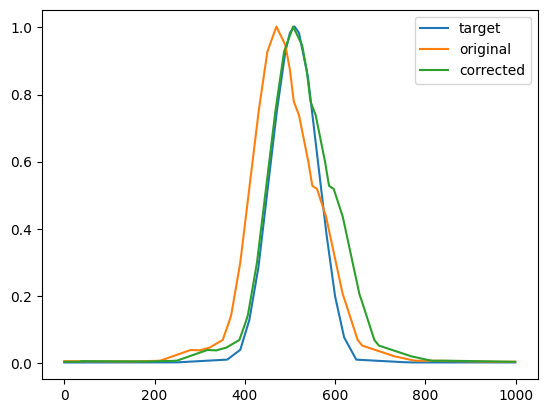

 44%|██████████████████▉                        | 22/50 [00:26<00:31,  1.13s/it]

42 -> 21, 185.0, 200


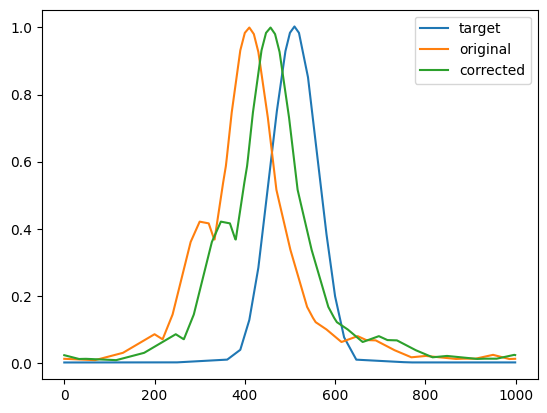

 46%|███████████████████▊                       | 23/50 [00:27<00:31,  1.16s/it]

42 -> 22, 235.0, 100


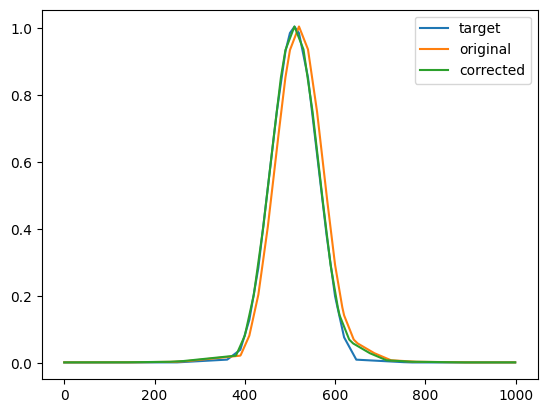

 48%|████████████████████▋                      | 24/50 [00:28<00:30,  1.19s/it]

42 -> 23, -50.0, -50


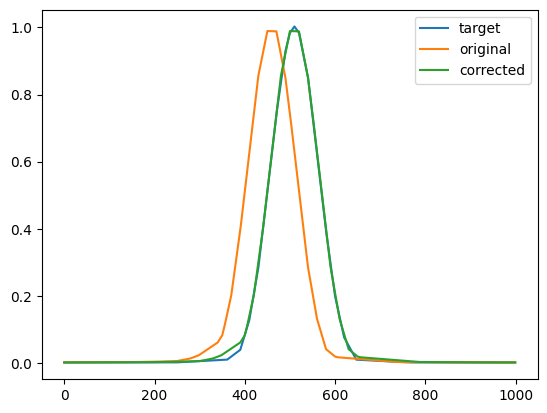

 50%|█████████████████████▌                     | 25/50 [00:30<00:29,  1.18s/it]

42 -> 24, 250.0, 250


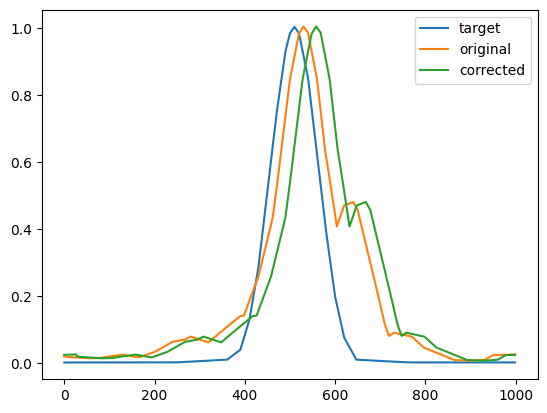

 52%|██████████████████████▎                    | 26/50 [00:31<00:27,  1.14s/it]

42 -> 25, 140.0, 300


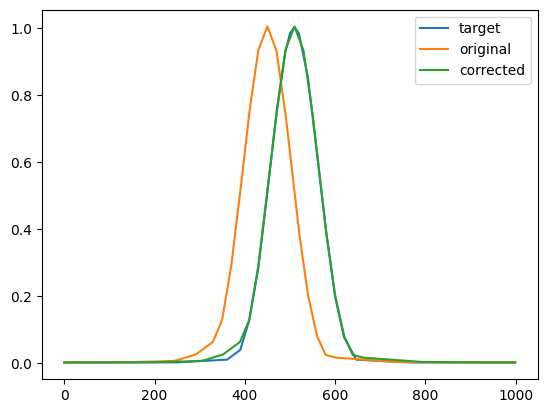

 54%|███████████████████████▏                   | 27/50 [00:32<00:26,  1.15s/it]

42 -> 26, 300.0, 300


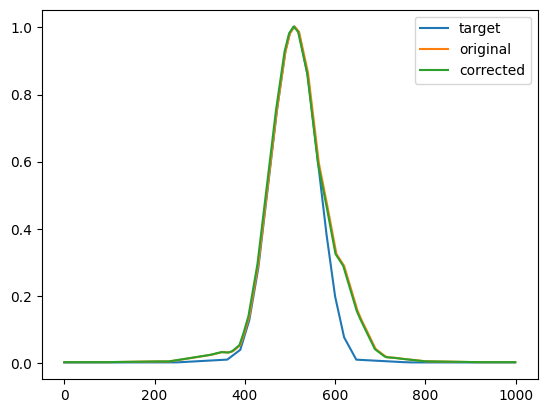

 56%|████████████████████████                   | 28/50 [00:33<00:24,  1.13s/it]

42 -> 27, -10.0, 0


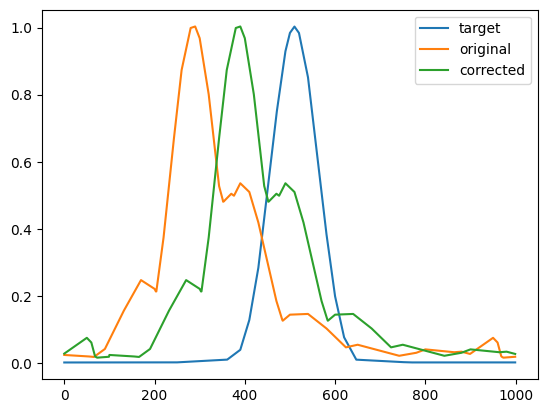

 58%|████████████████████████▉                  | 29/50 [00:34<00:23,  1.10s/it]

42 -> 28, 500.0, 200


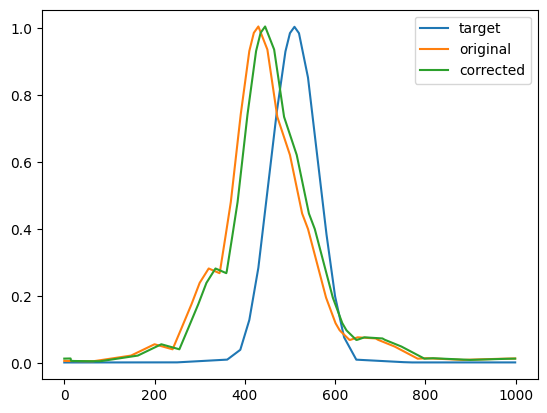

 60%|█████████████████████████▊                 | 30/50 [00:35<00:22,  1.14s/it]

42 -> 29, 75.0, 0


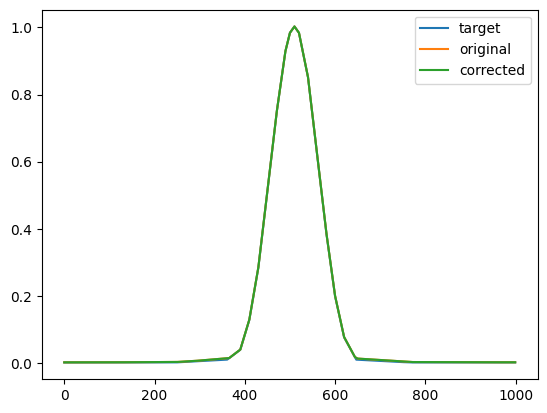

 62%|██████████████████████████▋                | 31/50 [00:36<00:21,  1.14s/it]

42 -> 30, 0.0, 0


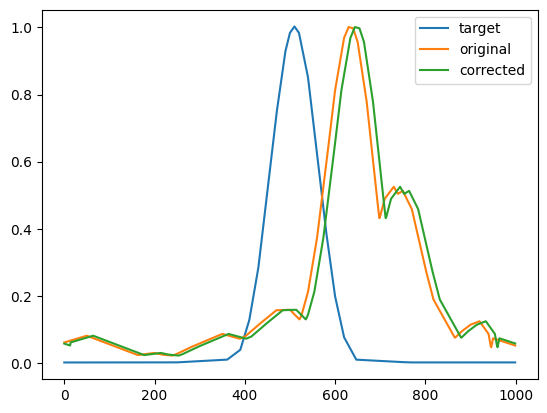

 64%|███████████████████████████▌               | 32/50 [00:37<00:20,  1.11s/it]

42 -> 31, 70.0, 300


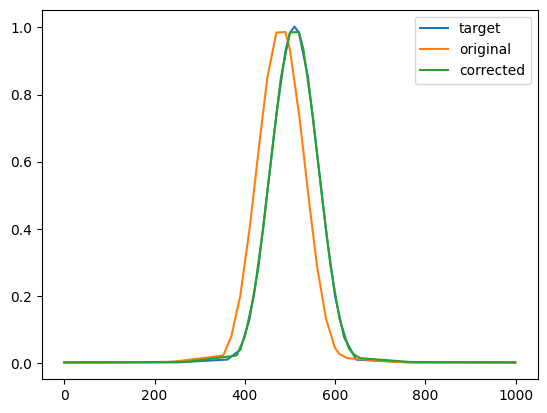

 66%|████████████████████████████▍              | 33/50 [00:39<00:19,  1.16s/it]

42 -> 32, 150.0, 150


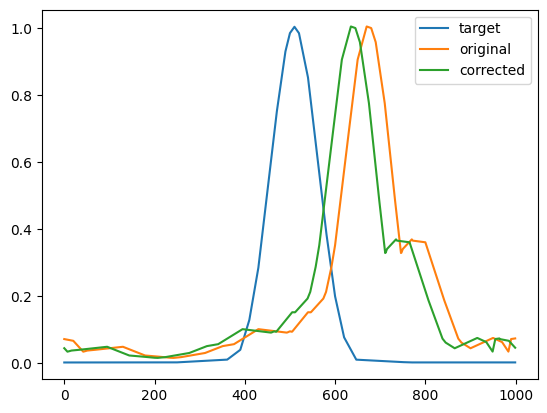

 68%|█████████████████████████████▏             | 34/50 [00:40<00:18,  1.18s/it]

42 -> 33, -175.0, 100


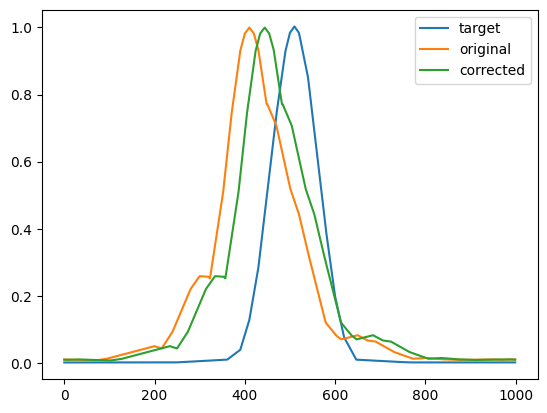

 70%|██████████████████████████████             | 35/50 [00:41<00:17,  1.19s/it]

42 -> 34, 170.0, 100


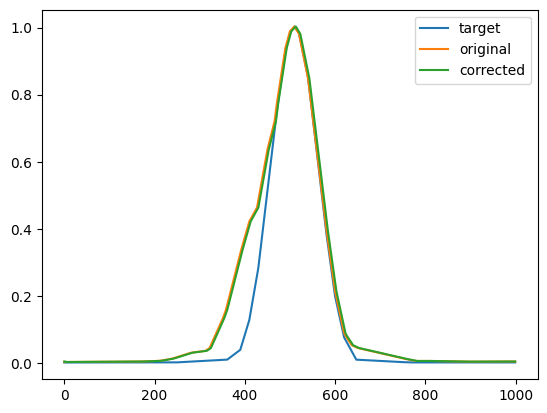

 72%|██████████████████████████████▉            | 36/50 [00:42<00:16,  1.20s/it]

42 -> 35, 15.0, 0


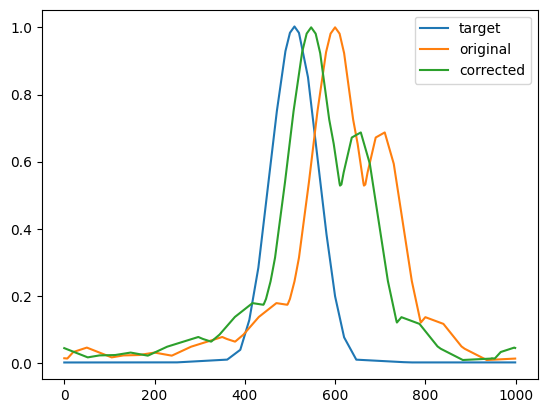

 74%|███████████████████████████████▊           | 37/50 [00:43<00:15,  1.17s/it]

42 -> 36, -265.0, -50


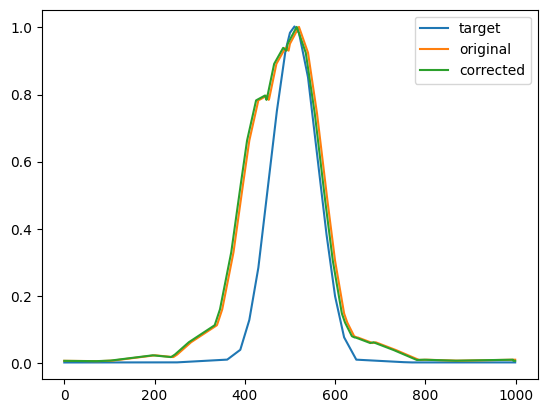

 76%|████████████████████████████████▋          | 38/50 [00:45<00:14,  1.20s/it]

42 -> 37, -25.0, -50


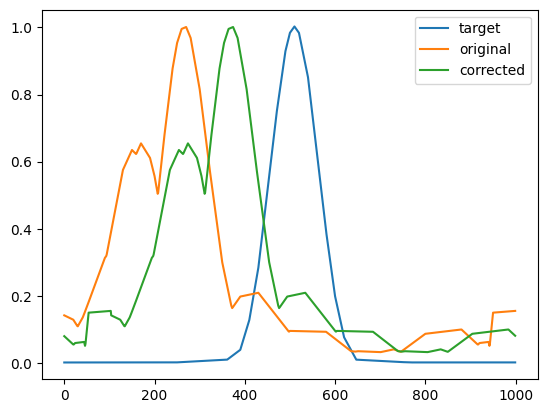

 78%|█████████████████████████████████▌         | 39/50 [00:46<00:13,  1.21s/it]

42 -> 38, 520.0, 300


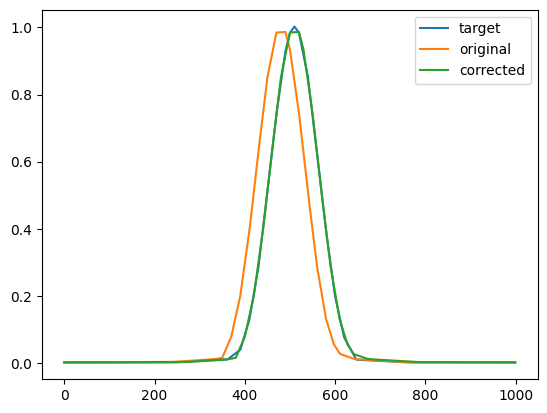

 80%|██████████████████████████████████▍        | 40/50 [00:47<00:11,  1.18s/it]

42 -> 39, 150.0, 150


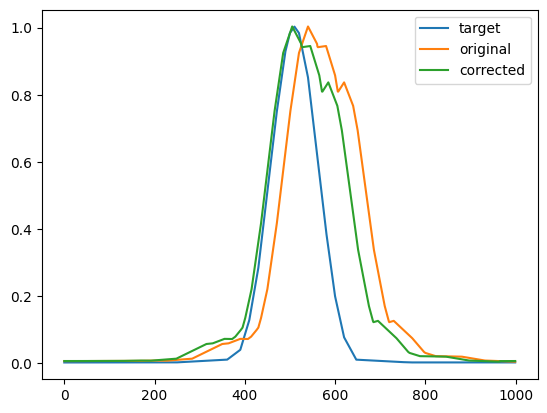

 82%|███████████████████████████████████▎       | 41/50 [00:48<00:10,  1.18s/it]

42 -> 40, -175.0, -150


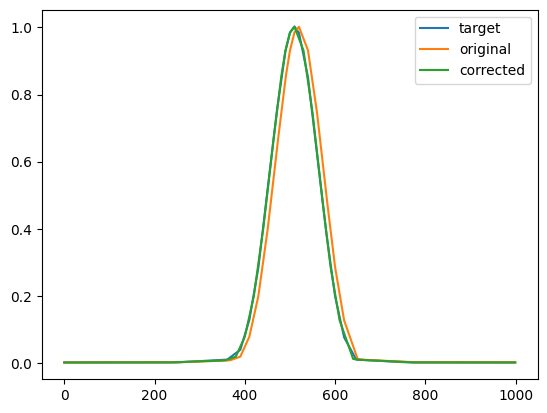

 84%|████████████████████████████████████       | 42/50 [00:49<00:09,  1.17s/it]

42 -> 41, -50.0, -50


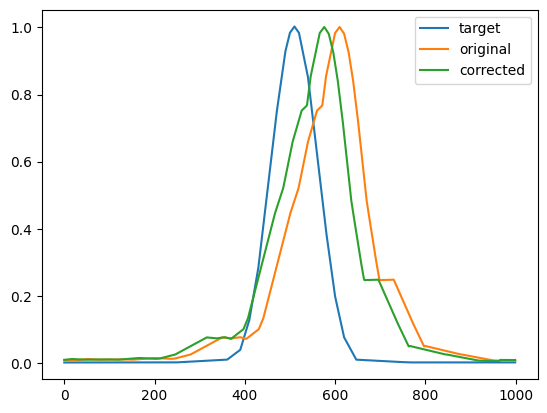

 88%|█████████████████████████████████████▊     | 44/50 [00:51<00:06,  1.01s/it]

42 -> 43, -170.0, -100


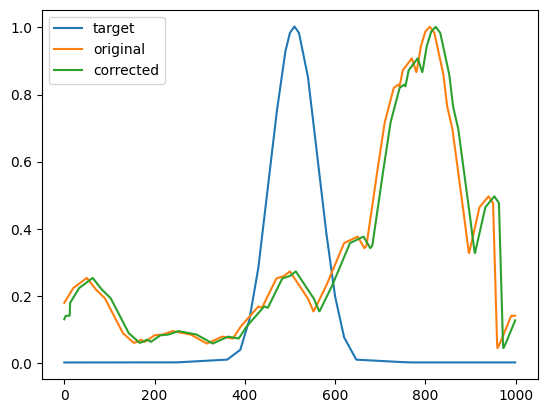

 90%|██████████████████████████████████████▋    | 45/50 [00:52<00:05,  1.08s/it]

42 -> 44, 65.0, 250


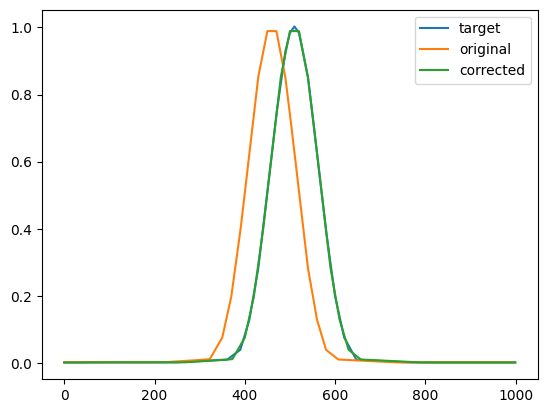

 92%|███████████████████████████████████████▌   | 46/50 [00:53<00:04,  1.10s/it]

42 -> 45, 250.0, 250


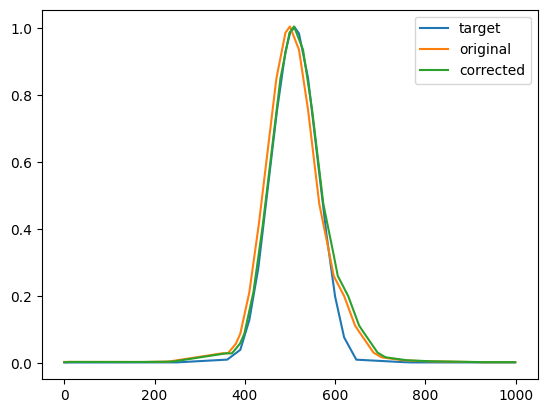

 94%|████████████████████████████████████████▍  | 47/50 [00:54<00:03,  1.12s/it]

42 -> 46, 45.0, 50


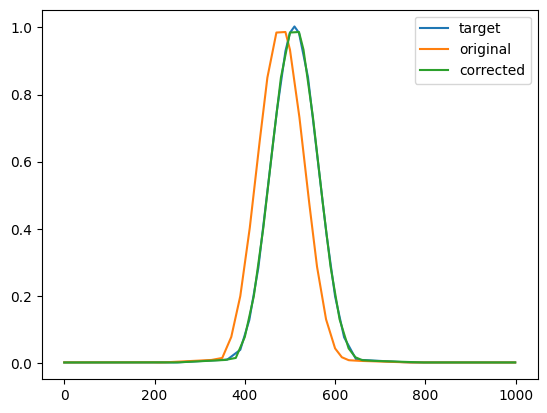

 96%|█████████████████████████████████████████▎ | 48/50 [00:55<00:02,  1.17s/it]

42 -> 47, 150.0, 150


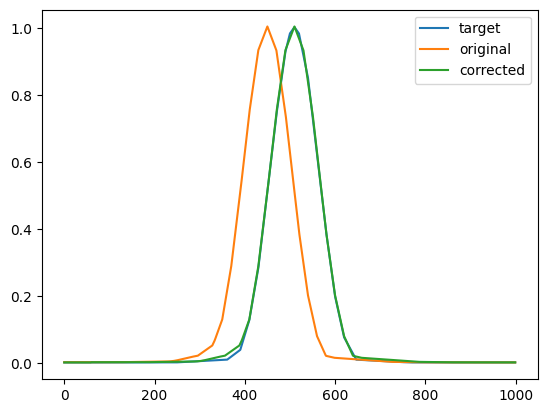

 98%|██████████████████████████████████████████▏| 49/50 [00:57<00:01,  1.21s/it]

42 -> 48, 300.0, 300


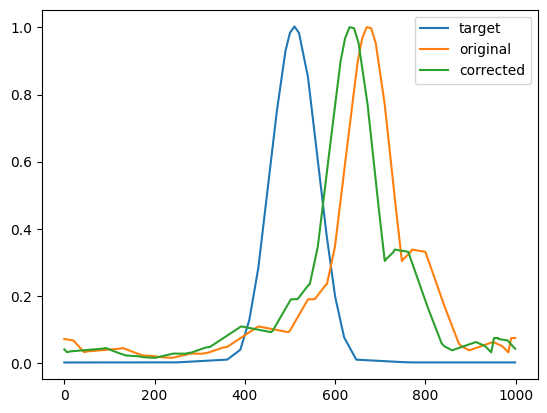

100%|███████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]

42 -> 49, -190.0, 100


In [12]:
import numpy as np
from skimage.exposure import match_histograms
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from multiprocessing import Pool
from itertools import product
from functools import partial
import tqdm
from data.estimate_offset import get_peak_sharpness
from data.visualise import show_psf_axial
from keras.losses import MeanSquaredError
from multiprocessing.spawn import prepare
import numpy as np
from scipy.interpolate import UnivariateSpline
from tqdm import trange
import tensorflow as tf

mse = MeanSquaredError()
DEBUG = False
UPSCALE_RATIO = 10
def norm_zero_one(s):
    max_s = s.max()
    min_s = s.min()
    return (s - min_s) / (max_s - min_s)


def pad_and_fit_spline(coords, psf, z, z_ups):
    x, y = coords
    zs = psf[:, x, y]
    cs = UnivariateSpline(z, zs, k=1, s=1e-3)
    if False:
        plt.scatter(z, zs, label='raw')
        plt.plot(z_ups, cs(z_ups), label='smooth')
        plt.legend()
        plt.show()
    return x, y, cs(z_ups)
    
def upsample_psf(psf, ratio=UPSCALE_RATIO):
    pad_width = 10
    z = np.arange(-pad_width, psf.shape[0] + pad_width)
    z_ups = np.arange(0, psf.shape[0], 1/ratio)
    upsampled_psf = np.zeros((z_ups.shape[0], *psf.shape[1:]))
    
    psf = np.pad(psf, ((pad_width, pad_width), (0, 0), (0, 0)), mode='edge')
    xys = list(product(np.arange(psf.shape[1]), np.arange(psf.shape[2])))
    func = partial(pad_and_fit_spline, psf=psf, z=z, z_ups=z_ups)
    res = list(map(func, xys))
    # with Pool(8) as p:
    #     res = list(p.imap(func, xys))
    for x, y, z_col in res:
        upsampled_psf[:, x, y] = z_col

    return upsampled_psf


def plot_correction(target, img, psf_corrected, errors):
    if True:
        plt.plot(target.max(axis=(1,2)), label='target')
        plt.plot(img.max(axis=(1,2)),  label='original')
        plt.plot(psf_corrected.max(axis=(1,2)), label='corrected', )

        plt.legend()
        plt.show()

        
mse = MeanSquaredError(reduction='sum')
def loss_func(true_m, pred_m):
    m = tf.math.abs(true_m-pred_m)
    m = tf.math.square(m*pred_m)
    return tf.math.reduce_mean(m)

def tf_find_optimal_roll(target, img, upscale_ratio=UPSCALE_RATIO):
    ref_tf = tf.convert_to_tensor(target)
    img_tf = tf.convert_to_tensor(img)
    errors = []

    for i in range(img.shape[0]):
#         error = loss_func(ref_tf, img_tf)
        error = mse(ref_tf, img_tf)
        errors.append(error)
        img_tf = tf.roll(img_tf, 1, axis=0)

    best_i = tf.argmin(errors).numpy()
    # Prefer small backwards roll to large forwards roll
    if abs(best_i - img.shape[0]) < best_i:
        best_i = best_i - img.shape[0]

    psf_corrected = np.roll(img, int(best_i), axis=0)
    plot_correction(target, img, psf_corrected, errors)

    return best_i/upscale_ratio

def prepare_psf(psf):
#     psf = gaussian(psf, sigma=1)
    psf = psf.copy()
    psf = np.square(psf)
    psf = norm_zero_one(psf)
    psf = upsample_psf(psf)
#     psf = mask_img_stack(psf, 12)
    return psf


def align_psfs(psf, psf2):
    psf = prepare_psf(psf)
    psf2 = prepare_psf(psf2)
    psf = match_histograms(psf, psf2)
    offset = tf_find_optimal_roll(psf, psf2)
    return offset * z_step

def find_seed_psf(df):
    # Seed PSF - most centered PSF in FOV
    center = df[['x', 'y']].mean(axis=0).to_numpy()
    coords = df[['x', 'y']].to_numpy()
    dists = euclidean_distances([center], coords).squeeze()
    first_point = np.argmin(dists)
    print(first_point)
    return first_point

def get_or_prepare_psf(prepped_psfs, raw_psfs, idx):
    if idx not in prepped_psfs:
        prepped_psfs[idx] = prepare_psf(raw_psfs[idx])
    return prepped_psfs[idx]

xys = df[['x', 'y']].to_numpy()

errors = []
def classic_align_psfs(psfs, df):
    print(f'Aligning {psfs.shape} psfs...')

    seed_psf = find_seed_psf(df)
    ref_psf = prepare_psf(psfs[seed_psf])
    offsets = np.zeros((psfs.shape[0]))

    ref_0 = get_peak_sharpness(psfs[seed_psf])

    for i in trange(0, psfs.shape[0]):
        if i == seed_psf:
            offsets[i] = 0
            errors.append(0)
            continue
        psf = psfs[i]
        psf = prepare_psf(psf)
#         psf = match_histograms(psf, ref_psf)
        offset = tf_find_optimal_roll(ref_psf, psf) * z_step
        offsets[i] = offset
        correct_dist = df['roll'][seed_psf] - df['roll'][i]
        euc_dist = euclidean_distances([xys[i]], [xys[seed_psf]]).squeeze()
        errors.append(correct_dist)
        print(f"{seed_psf} -> {i}, {offset}, {correct_dist}")
        if DEBUG:
            offset_psf = np.roll(psf, shift=-int(offset), axis=0)
            imgs = np.concatenate((ref_psf, offset_psf), axis=2)
            show_psf_axial(imgs, subsample_n=30)
            
#         plt.imshow(grid_psfs(psf[::5]).T)
#         plt.show()
#         plt.imshow(grid_psfs(ref_psf[::5]).T)
#         plt.show()

#     offsets -= ref_0

    return offsets

classic_offsets = classic_align_psfs(psfs, df)

best slice: 88


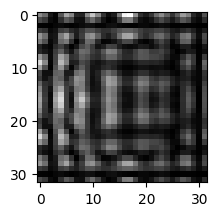

best slice: 8


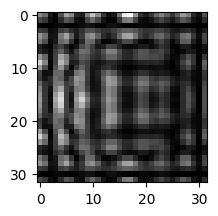

best slice: 7


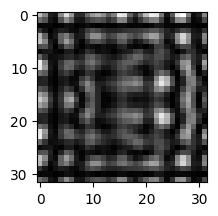

best slice: 45


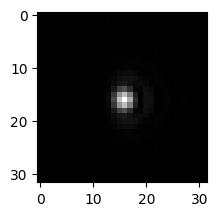

best slice: 90


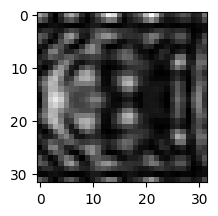

best slice: 7


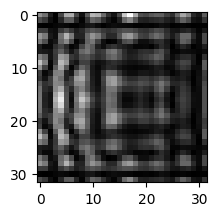

best slice: 52


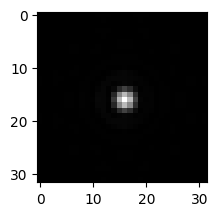

best slice: 55


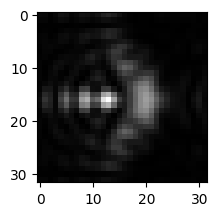

best slice: 7


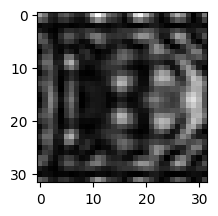

best slice: 48


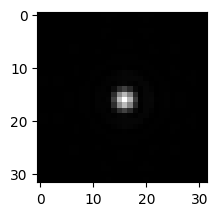

best slice: 47


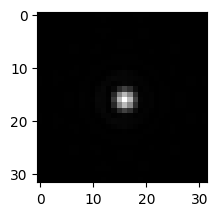

best slice: 84


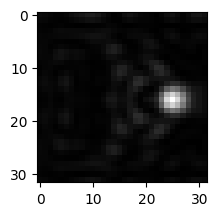

best slice: 48


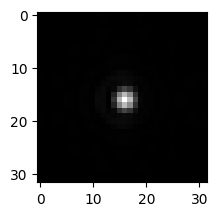

best slice: 59


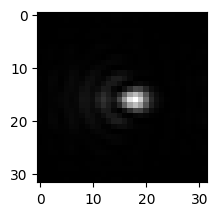

best slice: 10


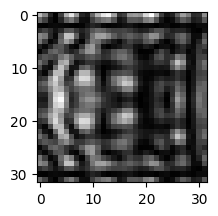

best slice: 60


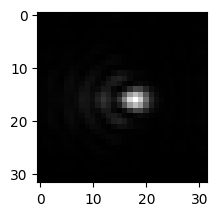

KeyboardInterrupt: 

In [28]:

import numpy as np
import scipy.optimize as opt
import skimage.filters as filters

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-(x - mean) ** 2 / (2 * stddev ** 2))

def measure_psf_fwhm(psf):
    # Normalize the PSF to range [0, 1]
    psf_norm = (psf - np.min(psf)) / (np.max(psf) - np.min(psf))
    
    # Find the center of the PSF using the maximum intensity
    center = np.unravel_index(np.argmax(psf_norm), psf_norm.shape)
    # Extract a 1D slice of the PSF along the z-axis passing through the center
    z_slice = psf_norm[:, center[0]]
    
    # Estimate the initial parameters of the Gaussian fit
    amplitude = np.max(z_slice) - np.min(z_slice)
    mean = center[0]
    stddev = 2
    
    # Fit the Gaussian to the 1D slice using least squares optimization
    try:
        popt, _ = opt.curve_fit(gaussian, np.arange(z_slice.size), z_slice, p0=[amplitude, mean, stddev])
    except RuntimeError:
        return np.inf
    # Compute the FWHM of the Gaussian fit
    fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]
    
    return fwhm

def determine_best_focus_slice(psf):
    # Measure the FWHM of the PSF for each z-slice
    fwhm_values = []
    for i in range(psf.shape[0]):
        fwhm = measure_psf_fwhm(psf[i])
        fwhm_values.append(fwhm)
    
    # Find the index of the z-slice with the minimum FWHM value
    best_slice_idx = np.argmin(fwhm_values)
    plt.rcParams['figure.figsize'] = [2, 2]
    print(f'best slice: {best_slice_idx}')
    slices = psf[[best_slice_idx-5, best_slice_idx, best_slice_idx], :, :]
    show_psf_axial(slices, '', 1)
    return best_slice_idx

def fwhm_offsets(psfs):
    idxs = np.array([determine_best_focus_slice(psf) for psf in psfs]).astype(float)
    idxs -= np.mean(idxs)
    return idxs

# measure_psf_fwhm(psfs[0][0])
new_offsets = fwhm_offsets(psfs)

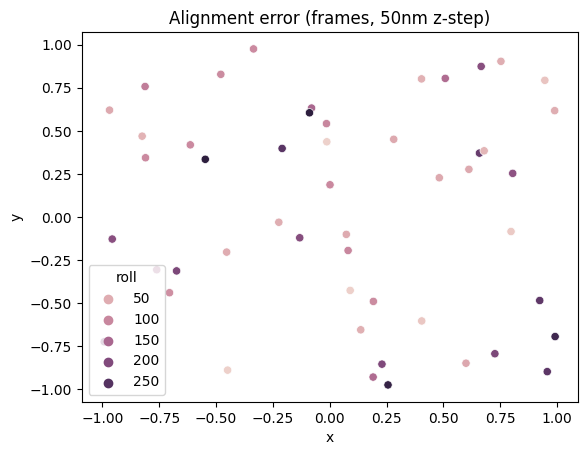

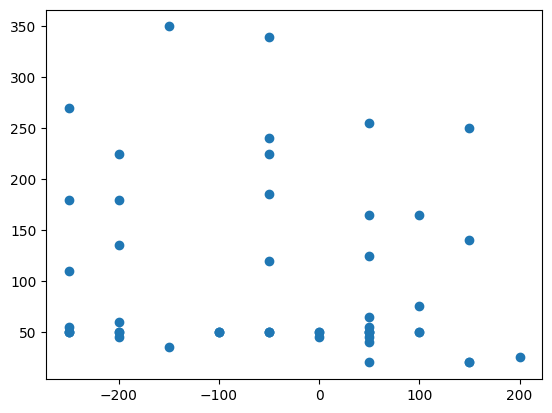

In [25]:
plt.title('Alignment error (frames, 50nm z-step)')
sns.scatterplot(data=df, x='x', y='y', hue=abs(df['roll']-new_offsets))
plt.show()
plt.scatter(df['roll'], abs(df['roll']+classic_offsets))
plt.show()

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils.graph_shortest_path import graph_shortest_path
import networkx as nx

def get_center_point(df):
    center_point = [[0, 0]]
    df['dists'] = euclidean_distances(df[['x', 'y']], center_point)
    idx = df['dists'].idxmin()
    return df.iloc[idx]

dists = euclidean_distances(df[['x', 'y']])

G = nx.from_numpy_matrix(dists)
G = nx.minimum_spanning_tree(G)
center_point = get_center_point(df)

from itertools import combinations
for src, target in G.edges:
    G[src][target]['weight'] = dists[src, target]

nx.draw(G, pos=df[['x', 'y']].values, with_labels=True, node_size=100, node_color='lightgreen')

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils.graph_shortest_path import graph_shortest_path
from tqdm import trange
import networkx as nx

UPSCALE_RATIO = 10

def pad_and_fit_spline(coords, psf, z, z_ups):
    x, y = coords
    zs = psf[:, x, y]
    cs = UnivariateSpline(z, zs, k=1, s=1e-6)
    if False:
        plt.scatter(z, zs, label='raw')
        plt.plot(z_ups, cs(z_ups), label='smooth')
        plt.legend()
        plt.show()
    return x, y, cs(z_ups)
    
def upsample_psf(psf, ratio=UPSCALE_RATIO):
    pad_width = 10
    z = np.arange(-pad_width, psf.shape[0] + pad_width)
    z_ups = np.arange(0, psf.shape[0], 1/ratio)
    upsampled_psf = np.zeros((z_ups.shape[0], *psf.shape[1:]))
    
    psf = np.pad(psf, ((pad_width, pad_width), (0, 0), (0, 0)), mode='edge')
    xys = list(product(np.arange(psf.shape[1]), np.arange(psf.shape[2])))
    func = partial(pad_and_fit_spline, psf=psf, z=z, z_ups=z_ups)
    res = list(map(func, xys))
    # with Pool(8) as p:
    #     res = list(p.imap(func, xys))
    for x, y, z_col in res:
        upsampled_psf[:, x, y] = z_col

    return upsampled_psf


def plot_correction(target, img, psf_corrected, errors):
    if True:
        plt.plot(target.max(axis=(1,2)), label='target')
        plt.plot(img.max(axis=(1,2)),  label='original')
        plt.plot(psf_corrected.max(axis=(1,2)), label='corrected', )

        plt.legend()
        plt.show()

        
mse = MeanSquaredError(reduction='sum')
def loss_func(true_m, pred_m):
    m = tf.math.abs(true_m-pred_m)
    m = tf.math.square(m*true_m)
    return tf.math.reduce_mean(m)

def tf_find_optimal_roll(target, img, upscale_ratio=UPSCALE_RATIO):
    ref_tf = tf.convert_to_tensor(target)
    img_tf = tf.convert_to_tensor(img)
    errors = []

    for i in range(img.shape[0]):
#         error = loss_func(ref_tf, img_tf)
        error = mse(ref_tf, img_tf)
        errors.append(error)
        img_tf = tf.roll(img_tf, 1, axis=0)

    best_i = tf.argmin(errors).numpy()
    # Prefer small backwards roll to large forwards roll
    if abs(best_i - img.shape[0]) < best_i:
        best_i = best_i - img.shape[0]

    psf_corrected = np.roll(img, int(best_i), axis=0)
    plot_correction(target, img, psf_corrected, errors)

    return best_i/upscale_ratio


def prepare_psf(psf):
#     psf = gaussian(psf, sigma=1)
    psf = psf.copy()
    psf = psf * psf
    psf = norm_zero_one(psf.copy())
    psf = upsample_psf(psf)
    # psf = mask_img_stack(psf, 12)
    return psf


def align_psfs(psf, psf2):
    psf = prepare_psf(psf)
    psf2 = prepare_psf(psf2)
    psf = match_histograms(psf, psf2)
    offset = tf_find_optimal_roll(psf, psf2)
    return offset * z_step

offsets = np.zeros((df.shape[0], df.shape[0]))
offsets[:] = None

src_node = 0
target_node = center_point.name
all_offsets = []
def get_path_offset(G, src_node, target_node):
    spath = nx.shortest_path(G, src_node, target_node)
    if not np.isnan(offsets[src, target]):
        cumul = offsets[src, target]
    else:
        cumul = 0
        for i in range(0, len(spath)-1):
            a, b = spath[i], spath[i+1]
            if not np.isnan(offsets[a, b]):
                offset = offsets[a, b]
            else:
                offset = align_psfs(psfs[a], psfs[b])
                offsets[a, b] = offset
                offsets[b, a] = -offset
                diff = (df['roll'][a] - df['roll'][b])
                print(f'{a} -> {b}: {offsets[a, b]}, {diff}')
            
            cumul += offset
        offsets[src_node, target_node] = cumul
        offsets[target_node, src_node] = -cumul
    all_offsets.append(cumul)
    
for i in trange(0, df.shape[0]):
    if i == target_node:
        all_offsets.append(0)
        continue
    get_path_offset(G, i, target_node)
all_offsets = np.array(all_offsets)

# def roll_psf(psf, roll):
#     rolled_psf = np.roll(psf, shift=roll, axis=0)
# #     if roll < 0:
# #         rolled_psf[roll:] = 0
# #     else:
# #         rolled_psf[:roll] = 0
#     return rolled_psf
# rolls = df['roll']
# print(rolls[5], rolls[6])
# psf = psfs[5]
# rolled_psf = roll_psf(psf, 10)
# print(align_psfs(psf, rolled_psf))



In [ ]:
print(classic_offsets.shape)
print(all_offsets.shape)

In [ ]:
import seaborn as sns
from sklearn.metrics import mean_absolute_error

plt.scatter(df['roll'], -classic_offsets-150, label='classic')
plt.scatter(df['roll'], all_offsets-150, label='new')
plt.plot(df['roll'], df['roll'], c='red', label='1')
plt.legend()
plt.show()

print(round(mean_absolute_error(df['roll'], -classic_offsets-150), 5))
print(round(mean_absolute_error(df['roll'], all_offsets-150), 5))


In [ ]:
co = -classic_offsets*50
sns.scatterplot(data=df, x='x', y='y', hue=co-co.min())
plt.title('Offsets [nm]')
plt.xlabel('x [nm]')
plt.ylabel('y [nm]')
plt.show()

In [ ]:
coords = df[['x', 'y']].to_numpy()
target_node_coords = coords[69]
dists = euclidean_distances(coords, [[0, 0]])
plt.scatter(df['x'], co-co.min())
plt.ylabel('offset [nm]')
plt.xlabel('x [nm]')
plt.show()
plt.scatter(df['y'], co-co.min())
plt.ylabel('offset [nm]')
plt.xlabel('y [nm]')
plt.show()

In [ ]:
import networkx as nx
G = nx.Graph()
for path in tri.simplices:
    nx.add_path(G, path)

from itertools import combinations
for src, target in G.edges:
    G[src][target]['weight'] = dists[src, target]

edge_weights = []
for edge in G.edges():
    src, target = edge
    edge_weights.append(offsets[src-1, target-1])
    
nx.draw(G, pos=df[['x', 'y']].values, edge_color=edge_weights, width=edge_weights, with_labels=True, node_size=100, node_color='lightgreen')

In [ ]:
z_step = 50
psf_z = np.arange(0, psfs.shape[1]) * z_step

psf2_z = (np.arange(0, psfs.shape[1]) * z_step) + overall_align

all_z = np.concatenate((psf_z, psf2_z))
all_psfs = np.concatenate((psfs[src_node], psfs[target_node]))
idx = np.argsort(all_z)
all_psfs = all_psfs[idx]

def norm_zero_one(psf):
    return (psf - psf.min()) / (psf.max() - psf.min())

all_psfs = np.stack([norm_zero_one(p) for p in all_psfs])

from data.visualise import grid_psfs

plt.imshow(grid_psfs(norm_zero_one(psfs[src_node])))
plt.show()


plt.imshow(grid_psfs(norm_zero_one(psfs[target_node])))
plt.show()

plt.imshow(grid_psfs(all_psfs))
plt.show()

In [ ]:
import pyotf
from tifffile import imread, imwrite

psf = imread('/home/miguel/Projects/uni/phd/smlm_z/test/psfs/20220506_Miguel_beads_zeiss_training_3_beads.tif')[0]

from pyotf.otf import HanserPSF
from pyotf.phaseretrieval import retrieve_phase
from pyotf.zernike import zernike

model_kwargs = dict(
    wl=0.647,
    na=1.3,
    ni=1.33,
    res=0.106,
    size=psf.shape[1],
    zsize=psf.shape[0],
    zres=0.01,
    vec_corr="none",
    condition="none",
)


In [ ]:
print(psf.shape)

In [ ]:
PR_result = retrieve_phase(
    psf, model_kwargs, max_iters=200, pupil_tol=0, mse_tol=0, phase_only=False
)


In [ ]:
PR_result.__dict__.keys()

In [ ]:
PR_result.plot()
PR_result.plot_convergence()
PR_result.fit_to_zernikes(64)
PR_result.zd_result.plot()
PR_result.zd_result.plot_named_coefs()
PR_result.zd_result.plot_coefs()

from pyotf.otf import apply_aberration
result_psf = HanserPSF(**model_kwargs)
result_psf = apply_aberration(result_psf, PR_result.zd_result.mcoefs, PR_result.zd_result.pcoefs)

In [ ]:
import numpy as np
from data.visualise import show_psf_axial
psfs = np.concatenate((psf, result_psf.PSFi), axis=2)
show_psf_axial(psfs)

In [ ]:
%load_ext autoreload
%autoreload 2
from data.datasets import TrainingPicassoDataset
from config.datasets import dataset_configs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

cfg = dataset_configs['paired_bead_stacks']['training_1']

locs = cfg['bpath'] / cfg['locs']
df = pd.read_hdf(locs, 'locs')
center = df[['x', 'y']].mean(axis=0).to_numpy()
coords = df[['x', 'y']].to_numpy()
dists = euclidean_distances([center], coords).squeeze()
df['dist_to_center'] = dists

first_point = np.argmin(dists)
df['source'] = False
df.loc[first_point, 'source'] = True

dists = euclidean_distances(coords, coords)
m = csr_matrix(dists)
tree = minimum_spanning_tree(m).toarray()
tree[tree>0] = 1
edges = np.where(tree>0)

abs_offsets = np.zeros((df.shape[0]))
abs_offsets[first_point] = 10

tree += tree.T
print(tree)
print(first_point)
alignable_psfs = set(np.argwhere(tree[first_point, :] > 0).squeeze())
while len(alignable_psfs):
    unaligned_psf = alignable_psfs.pop()
    known_offsets = set(np.argwhere(abs_offsets>0).flatten())
    connected_points = set(np.argwhere(tree[unaligned_psf, :] > 0).flatten())
    
    target_psf = known_offsets.intersection(connected_points).pop()
    abs_offsets[unaligned_psf] += abs_offsets[target_psf] + 1
    alignable_psfs = alignable_psfs.union(set(np.argwhere(tree[:, unaligned_psf]).flatten()))
    alignable_psfs = alignable_psfs.difference(np.argwhere(abs_offsets>0).flatten())

print(abs_offsets)

edges = np.where(tree>0)
for i in range(edges[0].shape[0]):
    src, target = edges[0][i], edges[1][i]
    x = [coords[src][0], coords[target][0]]
    y = [coords[src][1], coords[target][1]]
    plt.plot(x, y, color='0')
sns.scatterplot(data=df, x='x', y='y', hue=abs_offsets.astype(int))
plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2
from pyotf.otf import HanserPSF, apply_aberration, apply_named_aberration
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [5, 5]

from data.visualise import show_psf_axial, grid_psfs
from data.align_psfs import align_psfs, tf_find_optimal_roll, mask_img_stack, norm_zero_one

align_psfs.debug = False

kwargs = dict(
    wl=647,
    na=1.3,
    ni=1.51,
    res=106,
    zres=50,
    size=32,
    zsize=200,
    vec_corr="none",
    condition="none",
)
psf = HanserPSF(**kwargs)
psf = apply_aberration(psf, np.array([0, 0, 0, 0, 0]), np.array([0, 0, 0, 0, 1]))

blank_psf = psf.PSFi

blank_psf = norm_zero_one(blank_psf) * 255

from experiments.noise.noise_psf import EMCCD
import matplotlib.pyplot as plt
import numpy as np

e = EMCCD(noise_background=125)
e.add_noise(np.random.randint(0, 255, size=(32,32)))

psf = blank_psf[blank_psf.shape[0]//2]
plt.imshow(psf)
plt.show()
plt.imshow(e.add_noise(psf))
plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2
from experiments.noise.noise_psf import generate_noisy_psf
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [5, 5]

offset = 5
rolled_psf = np.roll(blank_psf, offset, axis=0)

rolled_psf = generate_noisy_psf(rolled_psf)
from skimage.exposure import match_histograms

psfs = np.stack((blank_psf, rolled_psf))
plt.plot(psfs[0].max(axis=(1,2)), label='target')
plt.plot(psfs[1].max(axis=(1,2)), label='psf')
plt.legend()
plt.show()

res = tf_find_optimal_roll(rolled_psf, blank_psf, 1)

offsets = [200, 200-res]

print('offsets', offsets)
assert res == -offset

imgs = np.concatenate(psfs)
zs = []
labels = ['target', 'psf']

for i, o in enumerate(offsets):
    vals = (np.arange(0, psfs[0].shape[0])*10) - (o*10)
    print(vals[0:5])
    plt.plot(vals, np.max(psfs[i], axis=(1,2)), label=labels[i])
plt.legend()
plt.show()



In [ ]:
from data.estimate_offset import get_peak_sharpness


fake_stacks = []
offsets = []
for offset in [0, 5, 10]:
    offsets.append(offset)
    rolled_psf = np.roll(blank_psf, offset, axis=0)
#     rolled_psf = generate_noisy_psf(rolled_psf)
    fake_stacks.append(rolled_psf)

fake_stacks = np.array(fake_stacks)
fake_stacks[fake_stacks<0] = 0

pos0 = (get_peak_sharpness(fake_stacks[0]) * 50) * 2
print(pos0)


In [ ]:
corr_offsets = align_psfs(fake_stacks)
plt.rcParams['figure.figsize'] = [5, 5]

print(corr_offsets)
voxel_size = 50
zs = []
for offset, psf in zip(corr_offsets, fake_stacks):
    z = ((np.arange(0, psf.shape[0]) - offset)  * voxel_size) -  pos0
    print(z.min(), z.max())
    zs.append(z)
    plt.plot(z, psf.max(axis=(1,2)))
plt.show()

    




In [ ]:
from data.datasets import stack_offset_to_z
zs = []
for psf, offset in zip(fake_stacks, corr_offsets):
    z = stack_offset_to_z(offset, psf, 10)
    print(z.min(), z.max())
    zs.append(z)

In [ ]:
# Inspect training dataset
from data.visualise import grid_psfs
plt.rcParams['figure.figsize'] = [50, 50]

zs = np.concatenate(zs)
imgs = np.concatenate(fake_stacks)
idx = np.argsort(zs)
imgs = imgs[idx]

plt.imshow(grid_psfs(imgs.squeeze()))
plt.show()





In [ ]:
import h5py

def read_spots(dirpath):
    f = h5py.File(dirpath, 'r')
    spots = np.array(f['spots'])[:, :, :, np.newaxis]
    f.close()
    return spots

dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_sim/grid_pairs/grid_pairs_spots.hdf5'
test_spots = read_spots(dirpath)

dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_test/training/NPC-A647-3D-BEADS/0021_spots.hdf5'

train_spots = read_spots(dirpath)

print(train_spots.shape)
print(test_spots.shape)
for spots in [train_spots, test_spots]:
    print(spots.min(), spots.mean(), spots.std(), spots.max())

In [ ]:
import matplotlib.pyplot as plt
from skimage.exposure import match_histograms

plt.rcParams['figure.figsize'] = [3, 3]
train_spot = train_spots[0]

mean_img = np.mean(train_spots, axis=0)

plt.imshow(train_spot)
plt.show()
plt.imshow(mean_img)
plt.show()
plt.imshow(match_histograms(train_spot, mean_img))
plt.show()

print(train_spot.min(), train_spot.max())

print(mean_img.min(), mean_img.max())

print(match_histograms(train_spot, mean_img).min(), match_histograms(train_spot, mean_img).max())

In [ ]:
import numpy as np
from skimage.exposure import equalize_hist
plt.rcParams['figure.figsize'] = [5,5]

mean_img = np.mean(train_spots, axis=0)

for i in range(0, 10):
    show_imgs(train_spots[i], match_histograms(train_spots[i], mean_img))

In [ ]:
%load_ext autoreload
%autoreload 2
from data.datasets import TrainingPicassoDataset
from config.datasets import dataset_configs

cfg = dataset_configs['paired_bead_stacks']['training_1']
print(cfg)

ds = TrainingPicassoDataset(cfg)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

radius = 107
n_elements = 8
z_depths = [0, 200]
offset = (0, 0)

angles = [i*((np.pi*2)/n_elements) for i in range(n_elements)]
x = np.array([np.cos(a)*radius for a in angles])
y = np.array([np.sin(a)*radius for a in angles])

x += offset[0]
y += offset[0]

xs = [round(n, 3) for n in np.concatenate((x, x))]
ys = [round(n, 3) for n in np.concatenate((y, y))]
zs = [round(n, 3) for n in (sorted(z_depths*n_elements))]

print(len(xs), len(ys), len(zs))

plt.scatter(xs, ys)
plt.show()

print(xs)
print(ys)
print(zs)

In [ ]:
dataset ='picasso_test'
BOUND = 31

from model.model import load_trained_model


model = load_trained_model(dataset)


In [ ]:
model.summary()

In [ ]:
'''
--------
|    x |   <- 50nm deeper than other
|      |
| x    |
--------

5 structures, frame 16 px,
structureX: 1000,3000
structureY: 1000,3000

structure3D: 0,50
ExchangeLabels:1,1
'''
dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_sim/50nm/50nm'

# dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_sim/grid_single/grid_single'
# dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_sim/grid_pairs/grid_pairs'

In [ ]:
import yaml

yaml_file = f'{dirpath}.yaml'

class SafeLoaderIgnoreUnknown(yaml.SafeLoader):
    def ignore_unknown(self, node):
        return None 

SafeLoaderIgnoreUnknown.add_constructor(None, SafeLoaderIgnoreUnknown.ignore_unknown)

with open(yaml_file, "r") as stream:
    root = yaml.load(stream, Loader=SafeLoaderIgnoreUnknown)
with open(yaml_file, "w") as stream:
    yaml.dump(root, stream)

In [ ]:
%load_ext autoreload
%autoreload 2

import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [5,5]

def norm_zero_one(img):
    img_max = img.max()
    img_min = img.min()
    return (img - img_min) / (img_max - img_min)

def norm_one_one(img):
    return (2 * norm_zero_one(img)) - 1 

locs = f'{dirpath}_locs.hdf5'
spots = f'{dirpath}_spots.hdf5'
print(locs)
print(spots)
df = pd.read_hdf(locs, 'locs')

f = h5py.File(spots, 'r')
spots = np.array(f['spots'])[:, :, :, np.newaxis]

df['id'] = np.arange(0, df.shape[0])
print(spots.shape)
print(df.shape, spots.shape)
f.close()

from data.visualise import grid_psfs
# plt.imshow(grid_psfs(spots.squeeze()))
# plt.show()

assert df.shape[0] == spots.shape[0]



from data.datasets import norm_dataset_from_config, standardise, load_ref_img_and_norm

print(spots.shape)
print(spots.min(), spots.max())
# spots = standardise(spots)
# spots = load_ref_img_and_norm(spots)
for s in spots[0:5]:
    print(s.min(), s.max())
    
spots = np.stack([norm_one_one(img) for img in spots])

print(spots.min(), spots.max())



In [ ]:
plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(grid_psfs(spots[0:50].squeeze()).squeeze())
plt.show()

mean_img = spots[1]

spots_matched_hist = np.stack([match_histograms(img, mean_img) for img in spots])
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(mean_img)
plt.show()
plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(grid_psfs(spots_matched_hist[0:50].squeeze()).squeeze())
plt.show()


In [ ]:
# # Rescale to [-1, 1]
# spots = np.stack([norm_one_one(img) for img in spots])


plt.gca().invert_yaxis()

df['index'] = np.arange(0, df.shape[0])
print(spots.shape)
plt.rcParams['figure.figsize'] = [5, 5]
sns.scatterplot(data=df, x='x', y='y', marker='+')
plt.show()


coords = np.zeros((spots.shape[0], 2))

pred = model.predict((spots_matched_hist, coords)).squeeze()
print(np.std(pred))
df['pred'] = pred
print(pred.min(), pred.max())

plt.rcParams['figure.figsize'] = [5, 5]
sns.histplot(pred, bins=50)
plt.xlabel('Z position (nm)')
plt.show()


sub_imgs = spots[0:100]
sub_preds = pred[0:100]
plt.rcParams['figure.figsize'] = [100, 100]
from data.visualise import grid_psfs
print(np.sort(sub_preds.squeeze()))

plt.imshow(grid_psfs(sub_imgs[np.argsort(sub_preds.squeeze())].squeeze()))
plt.show()

In [ ]:
print(np.std(pred))

In [ ]:
%load_ext autoreload
%autoreload 2

from config.datasets import dataset_configs

from data.datasets import TrainingDataSet, ExperimentalDataSet, GenericDataSet, MultiTrainingDataset, TrainingPicassoDataset

dataset = 'picasso_test'
version = ''
cfg = dataset_configs[dataset]['training']
print(cfg)

train_dataset = TrainingPicassoDataset(cfg)

In [ ]:
train_dataset.data['train'][0][0].max()

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]

test_imgs = spots.flatten()

plt.hist(test_imgs, label='exp', alpha=0.5)

for k in train_dataset.data.keys():
    imgs = train_dataset.data[k][0][0].flatten()
    print(imgs.min(), imgs.max())
    plt.hist(imgs.flatten(), label=k, alpha=0.5)

plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
mean_pixel_vals = np.mean(spots, axis=(1,2))
plt.rcParams['figure.figsize'] = [5, 5]
sns.kdeplot(mean_pixel_vals, pred)
plt.xlabel('Mean pixel value')
plt.ylabel('Pred')
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]
# df['emitter'] = df['x'] < 60
df['pred'] = pred.squeeze()
# df['pred2'] = df['pred']>-250
df['snr'] = [np.max(s)/np.median(s) for s in spots]
df['error'] = df['pred']+130
sns.scatterplot(data=df, x='snr', y='pred')
plt.show()
sns.scatterplot(data=df, x='snr', y='error')
plt.show()
# sns.histplot(daata=df, x='pred', hue='emitter')
# plt.show()

# sns.scatterplot(data=df, x='x', y='y', hue='pred2')
# plt.show()



In [ ]:
"""
Checks influence of polar coords on Z localisation
"""

# from itertools import product

# plt.rcParams['figure.figsize'] = [5, 5]

# spot = spots[0:1][:, :, :, np.newaxis]
# thetas = np.linspace(0, 1, 20)
# rhos = np.linspace(0, 1, 20)

# coords = np.array(list(product(thetas, rhos))).squeeze()
# spot = np.repeat(spot, coords.shape[0], axis=0)

# preds = model.predict((spot, coords))

# tmp_df = pd.DataFrame.from_dict({'theta': coords[:, 0], 'rho': coords[:, 1], 'z': preds.squeeze()})
# sns.scatterplot(data=tmp_df, x='theta', y='z')
# plt.show()
# sns.scatterplot(data=tmp_df, x='rho', y='z')
# plt.show()
# sns.scatterplot(data=tmp_df, x='theta', y='rho', hue='z')
# plt.show()

In [ ]:
# %load_ext autoreload
# %autoreload 2
# from config.datasets import dataset_configs
# from data.datasets import StormDataset, ExperimentalDataSet
# import seaborn as sns
# import matplotlib.pyplot as plt

# dataset ='picasso_test'

# cfg = dataset_configs[dataset]['nucleopore']
# ds = StormDataset(cfg, normalize_psf=True, lazy=True, apply_clustering=False)
# # ds.neighbour_radius = 15
# # ds.max_off_frames = 1000
# ds.csv_data = ds.csv_data[(ds.csv_data['x [nm]'] > 8250) 
#                           & (ds.csv_data['x [nm]'] < 8425) 
#                           & (ds.csv_data['y [nm]'] > 9425) 
#                           & (ds.csv_data['y [nm]'] < 9575) 
#                          ]

# plt.rcParams['figure.figsize'] = [5, 5]
# sns.scatterplot(data=ds.csv_data, x='x [nm]', y='y [nm]', marker='.')
# plt.show()


# ds.prepare_data()

# from scipy.ndimage import median_filter
# ds.data[0] = np.stack([median_filter(d, size=2) for d in ds.data[0]])

# df = ds.csv_data
# print(df.shape)
# print(ds.data[0].shape)

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN

plt.rcParams['figure.figsize'] = [5,5]

coords = df[['x', 'y']].to_numpy() * 100
distance_matrix = euclidean_distances(coords, coords)
eps = 15
min_count = 50

distance_matrix = (distance_matrix < eps).astype(int).sum(axis=0)
idx = np.argwhere(distance_matrix > min_count).squeeze()
sub_coords = coords[idx]
print(coords.shape)
print(sub_coords.shape)

cluster_ids = DBSCAN(eps=eps, min_samples=min_count).fit_predict(sub_coords)
sns.scatterplot(x=sub_coords[:, 0], y=sub_coords[:, 1], hue=cluster_ids.astype(str))
plt.axis('equal')
plt.show()

sub_df = df.iloc[idx]
sub_df['cluster_id'] = cluster_ids.squeeze().astype(str)
sub_spots = spots[idx]


In [ ]:
sns.histplot(model.predict((spots, np.zeros((spots.shape[0], 2)))).squeeze())
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from data.visualise import grid_psfs

plt.rcParams['figure.figsize'] = [20, 5]
# df['cluster_id'] = OPTICS().fit_predict(df[['x', 'y']].to_numpy()).squeeze().astype(str)
plt.axis('equal')
plt.title('Units: pixels (90nm each)')
sns.scatterplot(data=sub_df, x='x', y='y', marker='.', hue='cluster_id', legend=False)
plt.show()

n_components = 2

gm_mean_diffs = {}
mean_img_diffs = {}


def gm_min_bic(data, imgs):
    gm_df = pd.DataFrame({'pred': data.squeeze()}, index=np.arange(0, data.squeeze().shape[0]))

    best_gm = None
    min_bic = np.inf
    bics = []
    cov_type = 'tied'
    stdevs = []
    
    fig, axes = plt.subplots(1, 6)
    for n in range(1, 7):
        gm = GaussianMixture(n_components=n, n_init=20, covariance_type=cov_type).fit(data)
        bic = gm.bic(data)
        
        bics.append(round(bic, 3))
        stdevs.append(round(np.std(gm.weights_), 3))
        if bic < min_bic:
            min_bic = bic
            best_gm = gm
        
        ax = axes[n-1]
        labels = gm.predict(data).squeeze()

        gm_df['cluster_id'] = labels.astype(str)

        weights = gm.weights_

        sns.histplot(data=gm_df, x='pred', hue='cluster_id', stat='density', alpha=0.2, bins=20, ax=ax)

        # create necessary things to plot
        x_axis = np.linspace(data.min(), data.max(), 50)
        ys = []
        sub_df2 = pd.DataFrame.from_dict({'x': x_axis})
        for i in range(0, best_gm.n_components):
            if cov_type == 'tied':
                cov = gm.covariances_.squeeze()
            elif cov_type == 'full' or cov_type == None:
                cov = gm.covariances_[i][0][0]
            elif cov_type == 'spherical':
                cov = gm.covariances_[i]
            elif cov_type == 'diag':
                cov_type = gm.covariances_[i]

            sub_df2[f'y_{i}'] = norm.pdf(x_axis, float(gm.means_[i][0]), np.sqrt(cov))*gm.weights_[i]
            sns.lineplot(data=sub_df2, x='x', y=f'y_{i}', ax=ax)
    plt.show()        
        
    print(bics)
    print(stdevs)

    return best_gm.means_[:, 0]

def apply_gm(data, imgs, cid):
    data = data.reshape(-1, 1)
    gm_df = pd.DataFrame({'pred': list(data)})
    
    return gm_min_bic(data, imgs)
    

all_coords = []
for cid in set(sub_df['cluster_id']):
    if cid == '-1':
        continue
    idx = np.argwhere(sub_df['cluster_id'].to_numpy()==cid).squeeze()
    imgs = sub_spots[idx][:, :, :, np.newaxis]
    coords = np.zeros((imgs.shape[0], 2))
    preds = model.predict((imgs, coords)).squeeze()
    preds -= preds.min()
    preds += 0.00000001
    preds = np.sqrt(preds)
    z_pos = apply_gm(preds, imgs, cid)
    x, y = sub_df.iloc[idx][['x', 'y']].mean(axis=0).to_numpy() * 106
    coords = [[x, y, z, int(cid)] for z in z_pos]
    all_coords.extend(coords)

all_coords = np.array(all_coords)
res = pd.DataFrame.from_dict({
    k: all_coords[:, i] for k, i in zip(['x', 'y', 'z', 'cluster_id'], [0, 1, 2, 3])
})


In [ ]:
d = gm_mean_diffs
tops = [np.max(v) for k, v in d.items()]
bottoms = [np.min(v) for k, v in d.items()]
print(np.mean(tops))
print(np.mean(bottoms))
print(np.mean(tops) - np.mean(bottoms))

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
res['cluster_id'] = res['cluster_id'].astype(int)
fig = plt.figure()
fig.tight_layout() 

plt.subplots_adjust(wspace = 0.4) 
ax = fig.add_subplot(121, projection='3d')

ax.scatter(res['x'], res['y'], res['z'], marker='o', c=res['cluster_id'])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax2 = fig.add_subplot(122)

ax2.scatter(res['cluster_id'], res['z'], c=res['cluster_id'])
plt.xlabel('Cluster ID')
plt.title('All units in nm')
plt.show()

In [ ]:
print(spots.shape)
print(coords.shape)
all_coords = np.zeros((spots.shape[0], 2))
all_spots = spots[:, :, :, np.newaxis]

pred = model.predict((all_spots, all_coords))
df['z'] = pred.squeeze()
# for c in list(df):
#     sns.scatterplot(data=df, x=c, y='z')
#     plt.show()
sns.scatterplot(data=df.iloc[0:1000], x='frame', y='z')
plt.show()
sns.histplot(data=df, x='z')
plt.show()

In [ ]:

best_img = spots[0]

recs = []

imgs = []
coords = []

for _ in range(1000):
    noise_loc = np.random.uniform(0, 0.8)
    noise_scale = np.random.uniform(0, 0.7)
    new_img = np.random.normal(loc=noise_loc, scale=noise_scale, size=best_img.shape)
    new_img += best_img
    new_img = norm_zero_one(new_img)
    
    new_img = norm_zero_one(new_img)
    
    new_img = np.array([new_img])
    imgs.append(new_img)
    coords.append(np.zeros((1, 2)))
    
    recs.append({
        'img_mean': np.mean(new_img),
        'img_median': np.median(new_img),
        'noise_loc': noise_loc,
        'noise_scale': noise_scale,
    })

df = pd.DataFrame.from_dict(recs)

imgs = np.concatenate(imgs)
print(imgs.shape)
coords = np.concatenate(coords)
print(coords.shape)
pred = model.predict((imgs, coords)).squeeze()
err = pred
df['err'] = err
df['pred'] = pred
for col in list(df):
    sns.scatterplot(data=df, x=col, y='err')
    plt.show()
sns.scatterplot(data=df, x='noise_loc', y='noise_scale', hue='err')
plt.show()
